In [359]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
import cv2
import os
import torch
import numpy as np 
import pandas as pd 
from glob import glob
from tqdm import tqdm
import supervision as sv
import matplotlib.pyplot as plt
from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor

In [44]:
def plot_image_with_mask(img, mask, alpha=0.4):
    """
    Plots the image with an overlay of the mask in red, resizing the mask to match the image.

    Args:
    - img (str or numpy array): Path to the image file or image array.
    - mask (str or numpy array): Path to the mask file or mask array.
    - alpha (float): Transparency for overlaying mask.
    """

    # If img is a path, read the image file
    if isinstance(img, str):
        img = cv2.imread(img)

    # If mask is a path, read the mask file
    if isinstance(mask, str):
        mask = cv2.imread(mask)

    # Convert image from BGR to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the mask to match the image size
    mask_resized = cv2.resize(mask, (img_rgb.shape[1], img_rgb.shape[0]))

    # Combine all three channels of the mask by taking the max value across channels
    mask = np.clip(np.max(mask_resized, axis=2), 0, 1)

    # Create a colored mask (Red where the mask is 1, transparent elsewhere)
    colored_mask = np.zeros_like(img_rgb)  # Same shape as img, but all zeros
    colored_mask[:, :, 0] = mask * 255  # Red channel gets the mask values

    # Overlay the red mask on the original image using alpha blending
    overlay_img = cv2.addWeighted(img_rgb, 1 - alpha, colored_mask, alpha, 0)

    # Plot the image with the red mask overlay
    plt.figure(figsize=(5, 5))
    plt.imshow(overlay_img)
    plt.title("Image with Red Mask Overlay")
    plt.axis('off')
    plt.show()

In [59]:
masks = glob("../data/dataset/training_noisy_labels/*png")
images = [i.replace("training_noisy_labels", "training_patches") for i in masks]
len(images) , len(masks)

(5000, 5000)

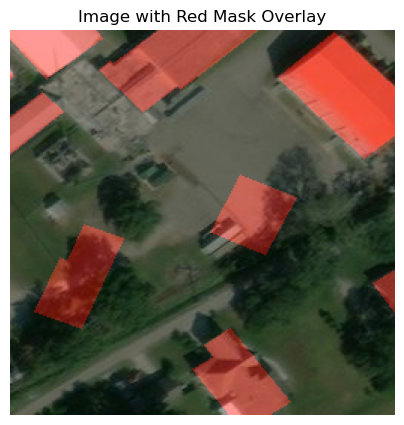

('../data/dataset/training_patches\\0_12_4_418_0.png',
 '../data/dataset/training_noisy_labels\\0_12_4_418_0.png')

In [6]:
idx = 100
plot_image_with_mask(images[idx], masks[idx])
images[idx], masks[idx]

In [7]:
# Grounding DINO
CONFIG_PATH = "../GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "../weights/groundingdino_swint_ogc.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=False
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

SAM_ENCODER_VERSION = "vit_b"
SAM_CHECKPOINT_PATH = "../weights/sam_vit_b_01ec64.pth"
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH)
sam_predictor = SamPredictor(sam)

In [9]:
classes = ["skyscrapers","buildings" , "house", "warehouses" ,"factory" ,"urban areas"]
BOX_TRESHOLD = 0.10
TEXT_TRESHOLD = 0.10

iou_list=[]
gd_model = Model(CONFIG_PATH, WEIGHTS_PATH , device=device)

final text_encoder_type: bert-base-uncased


In [10]:
import torch
import cv2

def calculate_iou(pred_mask, gt_mask):

    if isinstance(pred_mask, str):
        pred_mask = cv2.imread(pred_mask)

    if isinstance(gt_mask, str):
        gt_mask = cv2.imread(gt_mask)

    gt_mask = torch.from_numpy(gt_mask)
    pred_mask = torch.from_numpy(pred_mask)

    intersection = torch.sum(gt_mask*pred_mask)
    union = torch.sum(pred_mask) + torch.sum(gt_mask) - intersection

    iou = intersection / (union + 1e-6 )

    return iou.item()

***WITHOUT MULTIPROCESSING


In [11]:
from tqdm import tqdm
import os
import supervision as sv
import cv2
import numpy as np

classes = ["skyscrapers","buildings"]
BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.15


In [12]:

# for img_path , mask_path in tqdm(zip(images,masks), total=len(images)):
#     IMAGE_NAME = os.path.basename(img_path)
#     image = cv2.imread(img_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     detections  = gd_model.predict_with_classes(
#         image=image,
#         classes=classes,
#         box_threshold=BOX_TRESHOLD,
#         text_threshold=TEXT_TRESHOLD,
#     )
#     boxes = []
#     for box in detections.xyxy:
#         if ((box[2]-box[0])*(box[3]-box[1])<15000):
#             boxes.append(box)
#     detections.xyxy = np.array(boxes)
#     detections.mask = segment(
#         sam_predictor=sam_predictor,
#         image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
#         xyxy=detections.xyxy
#     )
    
#     pred_mask = detections.mask.astype(int)
#     if pred_mask.shape[0]==0:
#         pred_mask = np.zeros((image.shape[0],image.shape[1]))
#     else:
#         pred_mask = np.max(pred_mask , axis = 0)
    
#     pred_mask = np.stack([pred_mask]*3, axis=-1)
#     # output_path = img_path.replace('training_patches', 'pred_masks_sam_dino')
#     # os.makedirs(os.path.dirname(output_path), exist_ok=True)

#     # cv2.imwrite(output_path, pred_mask)
#     iou = calculate_iou(pred_mask , mask_path)
#     img_iou = [IMAGE_NAME , iou]
#     iou_list.append(img_iou)
#     break

In [82]:
import concurrent.futures
import os
import cv2
import numpy as np
from tqdm import tqdm

# Define the function to process each image and mask
def process_image_mask_pair(img_mask_pair):
    img_path, mask_path = img_mask_pair
    try:
        IMAGE_NAME = os.path.basename(img_path)
        output_path = img_path.replace('training_patches', 'pred_masks_sam_dino')
        if os.path.exists(output_path):
            pass
            # print("exists", output_path)
        else:
            
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            detections = gd_model.predict_with_classes(
                image=image,
                classes=classes,
                box_threshold=BOX_TRESHOLD,
                text_threshold=TEXT_TRESHOLD,
            )
    
            boxes = []
            for box in detections.xyxy:
                if ((box[2] - box[0]) * (box[3] - box[1]) < 15000):
                    boxes.append(box)
    
            detections.xyxy = np.array(boxes)
    
            # Segmenting using the provided SAM model
            detections.mask = segment(
                sam_predictor=sam_predictor,
                image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
                xyxy=detections.xyxy
            )
    
            pred_mask = detections.mask.astype(int)
            if pred_mask.shape[0] == 0:
                pred_mask = np.zeros((image.shape[0], image.shape[1]))
            else:
                pred_mask = np.max(pred_mask, axis=0)
    
            pred_mask = np.stack([pred_mask] * 3, axis=-1)
    
            
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            cv2.imwrite(output_path, pred_mask)
    except Exception as e:
        # Log or return the error for troubleshooting
        print(img_path, f"Error: {str(e)}")


In [116]:
# for pair in tqdm(zip(images, masks), total=5000):
#     process_image_mask_pair(pair)

In [14]:
# Use ThreadPoolExecutor for parallel processing
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    # Create pairs of images and masks
    img_mask_pairs = list(zip(images, masks))
    
    # Submit tasks to executor
    futures = {executor.submit(process_image_mask_pair, pair): pair for pair in img_mask_pairs}
    
    # Use tqdm to track progress
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing images"):
        future.result()  # Get the result of each processed pair

existsexists ../data/dataset/pred_masks_sam_dino\0_10_2_1044_209.png
 ../data/dataset/pred_masks_sam_dino\0_10_2_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_10_2_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_10_2_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_10_2_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_10_2_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_10_2_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_10_2_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_10_2_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_10_2_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_10_2_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_10_2_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_10_2_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_10_2_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_10_3_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_10_3_1044_209.png
exi

Processing images:   0%|                                                                                                                                                                                                                                                                                                                                                                                     | 0/5000 [00:00<?, ?it/s]

existsexists ../data/dataset/pred_masks_sam_dino\0_12_4_836_627.png
exists ../data/dataset/pred_masks_sam_dino\0_12_5_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_12_4_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_12_5_1044_836.png
 ../data/dataset/pred_masks_sam_dino\0_12_4_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_12_5_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_12_5_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_13_16_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_12_5_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_12_5_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_13_2_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_13_16_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_13_1_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_13_2_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_13_2_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_13_2_836_0.png
exists ../data/

Processing images:   5%|███████████████████▏                                                                                                                                                                                                                                                                                                                                                       | 264/5000 [00:11<03:29, 22.65it/s]

exists ../data/dataset/pred_masks_sam_dino\0_15_7_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_15_7_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_15_7_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_15_7_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_15_7_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_15_8_0_627.png


Processing images:   5%|███████████████████▋                                                                                                                                                                                                                                                                                                                                                       | 272/5000 [00:12<03:31, 22.31it/s]

../data/dataset/training_patches\0_15_7_209_418.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_15_8_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_15_8_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_15_8_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_15_8_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_15_8_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_15_8_209_418.png
../data/dataset/training_patches\0_15_7_0_418.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_15_8_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_15_8_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_15_8_418_627.png


Processing images:   6%|████████████████████▉                                                                                                                                                                                                                                                                                                                                                      | 288/5000 [00:23<08:51,  8.87it/s]

exists ../data/dataset/pred_masks_sam_dino\0_15_8_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_15_8_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_15_8_836_1044.png


Processing images:   6%|█████████████████████▎                                                                                                                                                                                                                                                                                                                                                     | 294/5000 [00:35<19:25,  4.04it/s]

exists ../data/dataset/pred_masks_sam_dino\0_15_9_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_15_9_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_16_10_418_0.png
exists ../data/dataset/pred_masks_sam_dino\0_16_12_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_16_12_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_16_12_1044_627.png


Processing images:   6%|█████████████████████▊                                                                                                                                                                                                                                                                                                                                                     | 300/5000 [00:46<36:10,  2.17it/s]

exists ../data/dataset/pred_masks_sam_dino\0_16_13_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_16_13_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_16_13_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_16_14_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_16_2_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_16_4_209_1044.png


Processing images:   6%|██████████████████████▎                                                                                                                                                                                                                                                                                                                                                    | 307/5000 [00:47<32:08,  2.43it/s]

../data/dataset/training_patches\0_16_12_1044_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:   6%|██████████████████████▍                                                                                                                                                                                                                                                                                                                                                  | 311/5000 [00:58<1:04:02,  1.22it/s]

../data/dataset/training_patches\0_16_4_209_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\0_16_4_418_1044.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_16_5_1044_1044.png
../data/dataset/training_patches\0_16_4_418_627.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_16_5_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_16_5_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_16_5_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_16_5_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_16_5_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_16_5_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_16_5_836_627.png
exists ../data/dataset/pred_masks_sam_dino\0_16_66_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_16_66_209_1044.png
ex

Processing images:   7%|████████████████████████▉                                                                                                                                                                                                                                                                                                                                                  | 343/5000 [01:09<36:20,  2.14it/s]

exists ../data/dataset/pred_masks_sam_dino\0_17_11_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_17_11_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_17_11_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_17_11_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_17_11_627_1044.png


Processing images:   7%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                                                 | 348/5000 [01:20<57:43,  1.34it/s]

../data/dataset/training_patches\0_17_11_627_209.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_17_11_836_627.png
../data/dataset/training_patches\0_17_11_836_1044.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_17_12_0_418.png


Processing images:   7%|█████████████████████████▎                                                                                                                                                                                                                                                                                                                                               | 351/5000 [01:28<1:24:53,  1.10s/it]

../data/dataset/training_patches\0_17_11_836_836.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_17_12_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_17_12_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_17_12_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_17_12_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_17_12_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_17_12_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_17_12_418_836.png
../data/dataset/training_patches\0_17_11_836_418.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_17_12_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_17_12_836_209.png


Processing images:   7%|██████████████████████████▎                                                                                                                                                                                                                                                                                                                                              | 365/5000 [01:39<1:08:30,  1.13it/s]

exists ../data/dataset/pred_masks_sam_dino\0_17_12_836_627.png
exists ../data/dataset/pred_masks_sam_dino\0_17_14_418_836.png
exists ../data/dataset/pred_masks_sam_dino\0_17_15_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_17_15_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_17_5_0_1044.png


Processing images:   8%|███████████████████████████▎                                                                                                                                                                                                                                                                                                                                             | 379/5000 [01:51<1:00:59,  1.26it/s]

exists ../data/dataset/pred_masks_sam_dino\0_17_68_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_17_68_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_17_6_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_17_6_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_17_7_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_18_11_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_18_11_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_18_12_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_18_12_0_209.png


Processing images:   8%|███████████████████████████▉                                                                                                                                                                                                                                                                                                                                             | 387/5000 [02:04<1:19:09,  1.03s/it]

exists ../data/dataset/pred_masks_sam_dino\0_18_12_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_18_12_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_18_12_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_18_12_418_0.png


Processing images:   8%|████████████████████████████▌                                                                                                                                                                                                                                                                                                                                            | 395/5000 [02:15<1:27:18,  1.14s/it]

exists ../data/dataset/pred_masks_sam_dino\0_18_13_1044_836.png


Processing images:   8%|████████████████████████████▋                                                                                                                                                                                                                                                                                                                                            | 398/5000 [02:25<2:06:37,  1.65s/it]

exists ../data/dataset/pred_masks_sam_dino\0_18_13_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_18_13_836_1044.png


Processing images:   8%|████████████████████████████▉                                                                                                                                                                                                                                                                                                                                            | 401/5000 [02:25<1:36:54,  1.26s/it]

exists ../data/dataset/pred_masks_sam_dino\0_18_14_1044_0.png


Processing images:   8%|█████████████████████████████▏                                                                                                                                                                                                                                                                                                                                           | 404/5000 [02:26<1:15:02,  1.02it/s]

exists ../data/dataset/pred_masks_sam_dino\0_18_15_0_209.png


Processing images:   8%|█████████████████████████████▍                                                                                                                                                                                                                                                                                                                                           | 407/5000 [02:36<2:01:09,  1.58s/it]

exists ../data/dataset/pred_masks_sam_dino\0_18_19_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_18_19_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_18_69_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_18_9_627_418.png


Processing images:   8%|██████████████████████████████▍                                                                                                                                                                                                                                                                                                                                          | 421/5000 [02:47<1:07:06,  1.14it/s]

exists ../data/dataset/pred_masks_sam_dino\0_19_11_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_19_12_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_19_13_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_19_13_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_19_13_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_19_13_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_19_13_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_19_13_418_836.png
exists ../data/dataset/pred_masks_sam_dino\0_19_13_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_19_13_836_627.png
exists ../data/dataset/pred_masks_sam_dino\0_19_13_836_836.png


Processing images:   9%|███████████████████████████████▎                                                                                                                                                                                                                                                                                                                                         | 434/5000 [02:58<1:00:23,  1.26it/s]

exists ../data/dataset/pred_masks_sam_dino\0_19_17_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_19_17_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_19_66_1044_209.png


Processing images:   9%|███████████████████████████████▌                                                                                                                                                                                                                                                                                                                                         | 438/5000 [03:09<1:35:27,  1.26s/it]

exists ../data/dataset/pred_masks_sam_dino\0_19_66_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_19_66_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_19_67_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_19_67_418_627.png


Processing images:   9%|███████████████████████████████▉                                                                                                                                                                                                                                                                                                                                         | 443/5000 [03:12<1:20:15,  1.06s/it]

exists ../data/dataset/pred_masks_sam_dino\0_19_67_627_627.png


Processing images:   9%|████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                        | 450/5000 [03:21<1:18:20,  1.03s/it]

exists ../data/dataset/pred_masks_sam_dino\0_19_68_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_20_11_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_20_11_0_209.png


Processing images:   9%|████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                        | 453/5000 [03:31<2:02:54,  1.62s/it]

exists ../data/dataset/pred_masks_sam_dino\0_20_17_418_836.png


Processing images:   9%|█████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                       | 462/5000 [03:43<1:36:28,  1.28s/it]

exists ../data/dataset/pred_masks_sam_dino\0_20_65_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_20_65_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_20_65_209_627.png


Processing images:   9%|█████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                       | 465/5000 [03:54<2:28:17,  1.96s/it]

exists ../data/dataset/pred_masks_sam_dino\0_20_66_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_0_1044.png


Processing images:   9%|█████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                       | 469/5000 [04:05<2:46:22,  2.20s/it]

exists ../data/dataset/pred_masks_sam_dino\0_20_66_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_1044_209.png


Processing images:   9%|██████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                      | 474/5000 [04:05<1:46:05,  1.41s/it]

exists ../data/dataset/pred_masks_sam_dino\0_20_66_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_209_627.png


Processing images:  10%|██████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                      | 480/5000 [04:08<1:16:27,  1.02s/it]

exists ../data/dataset/pred_masks_sam_dino\0_20_66_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_418_836.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_627_0.png


Processing images:  10%|███████████████████████████████████                                                                                                                                                                                                                                                                                                                                      | 486/5000 [04:15<1:22:57,  1.10s/it]

exists ../data/dataset/pred_masks_sam_dino\0_20_66_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_627_627.png


Processing images:  10%|███████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                       | 492/5000 [04:16<54:14,  1.39it/s]

../data/dataset/training_patches\0_20_66_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_20_66_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_20_66_836_209.png
../data/dataset/training_patches\0_20_66_209_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  10%|███████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                     | 494/5000 [04:21<1:19:28,  1.06s/it]

exists ../data/dataset/pred_masks_sam_dino\0_20_68_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_21_19_1044_1044.png


Processing images:  10%|████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                      | 504/5000 [04:27<41:25,  1.81it/s]

../data/dataset/training_patches\0_20_67_627_627.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_21_19_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_21_19_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_21_19_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_21_19_836_627.png
exists ../data/dataset/pred_masks_sam_dino\0_21_19_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_21_20_1044_0.png
../data/dataset/training_patches\0_20_66_836_418.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_21_20_1044_418.png


Processing images:  10%|████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                    | 506/5000 [04:36<1:37:20,  1.30s/it]

exists ../data/dataset/pred_masks_sam_dino\0_21_20_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_21_20_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_21_20_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_21_20_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_21_20_836_1044.png


Processing images:  10%|█████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                     | 513/5000 [04:36<52:26,  1.43it/s]

../data/dataset/training_patches\0_21_19_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  10%|█████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                     | 515/5000 [04:37<45:32,  1.64it/s]

../data/dataset/training_patches\0_21_19_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_21_20_836_836.png


Processing images:  10%|█████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                   | 517/5000 [04:47<1:51:14,  1.49s/it]

exists ../data/dataset/pred_masks_sam_dino\0_21_21_1044_0.png


Processing images:  10%|█████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                   | 520/5000 [04:48<1:19:48,  1.07s/it]

../data/dataset/training_patches\0_21_20_836_418.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_21_21_418_1044.png


Processing images:  10%|█████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                   | 524/5000 [04:59<2:04:05,  1.66s/it]

exists ../data/dataset/pred_masks_sam_dino\0_21_21_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_21_21_627_209.png


Processing images:  11%|██████████████████████████████████████                                                                                                                                                                                                                                                                                                                                   | 528/5000 [05:10<2:40:48,  2.16s/it]

exists ../data/dataset/pred_masks_sam_dino\0_21_21_836_0.png


Processing images:  11%|██████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                  | 530/5000 [05:10<2:03:54,  1.66s/it]

exists ../data/dataset/pred_masks_sam_dino\0_21_21_836_418.png
../data/dataset/training_patches\0_21_21_418_627.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_21_66_0_418.png


Processing images:  11%|██████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                  | 535/5000 [05:21<2:20:14,  1.88s/it]

exists ../data/dataset/pred_masks_sam_dino\0_22_20_0_0.png


Processing images:  11%|██████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                  | 537/5000 [05:21<1:52:30,  1.51s/it]

exists ../data/dataset/pred_masks_sam_dino\0_22_20_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_22_20_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_22_20_0_627.png


Processing images:  11%|███████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                   | 543/5000 [05:21<57:36,  1.29it/s]

../data/dataset/training_patches\0_21_66_0_0.png Error: repeat_interleave() received an invalid combination of arguments - got (NoneType, int, dim=int), but expected one of:
 * (Tensor input, Tensor repeats, int dim = None, *, int output_size = None)
 * (Tensor repeats, *, int output_size = None)
      didn't match because some of the keywords were incorrect: dim
 * (Tensor input, int repeats, int dim = None, *, int output_size = None)

../data/dataset/training_patches\0_21_22_418_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\0_22_21_0_209.png Error: 'GroundingDINO' object has no attribute 'poss'


Processing images:  11%|███████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                 | 545/5000 [05:32<2:16:48,  1.84s/it]

exists ../data/dataset/pred_masks_sam_dino\0_22_62_1044_1044.png


Processing images:  11%|███████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                 | 549/5000 [05:38<2:13:57,  1.81s/it]

exists ../data/dataset/pred_masks_sam_dino\0_22_63_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_22_63_836_0.png


Processing images:  11%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                 | 553/5000 [05:42<1:37:03,  1.31s/it]

../data/dataset/training_patches\0_22_62_1044_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  11%|███████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                 | 554/5000 [05:48<3:00:25,  2.43s/it]

exists ../data/dataset/pred_masks_sam_dino\0_22_69_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_22_70_418_627.png


Processing images:  11%|████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                | 558/5000 [05:52<1:53:02,  1.53s/it]

exists ../data/dataset/pred_masks_sam_dino\0_22_70_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_23_17_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_23_17_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_23_17_627_1044.png


Processing images:  11%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                  | 563/5000 [05:52<51:17,  1.44it/s]

exists ../data/dataset/pred_masks_sam_dino\0_23_18_1044_0.png


Processing images:  11%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                | 565/5000 [06:02<2:05:47,  1.70s/it]

exists ../data/dataset/pred_masks_sam_dino\0_23_18_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_23_18_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_23_18_418_209.png


Processing images:  11%|█████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                               | 570/5000 [06:02<1:06:57,  1.10it/s]

exists ../data/dataset/pred_masks_sam_dino\0_23_18_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_23_62_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_23_62_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_23_62_209_1044.png


Processing images:  12%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                 | 575/5000 [06:03<38:01,  1.94it/s]

../data/dataset/training_patches\0_23_18_1044_209.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_23_62_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_23_62_418_1044.png


Processing images:  12%|██████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                | 585/5000 [06:13<52:02,  1.41it/s]

exists ../data/dataset/pred_masks_sam_dino\0_23_62_418_836.png
exists ../data/dataset/pred_masks_sam_dino\0_23_63_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_23_66_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_23_66_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_23_69_0_209.png


Processing images:  12%|███████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                               | 595/5000 [06:24<57:13,  1.28it/s]

exists ../data/dataset/pred_masks_sam_dino\0_24_18_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_24_18_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_24_18_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_24_18_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_24_18_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_24_21_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_24_67_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_24_67_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_24_67_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_24_70_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_24_70_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_24_70_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_24_70_209_836.png


Processing images:  12%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                             | 604/5000 [06:36<1:12:33,  1.01it/s]

exists ../data/dataset/pred_masks_sam_dino\0_25_68_418_0.png
exists ../data/dataset/pred_masks_sam_dino\0_25_68_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_25_70_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_25_70_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_25_70_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_25_70_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_25_70_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_25_70_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_25_70_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_25_70_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_25_70_418_836.png
exists ../data/dataset/pred_masks_sam_dino\0_25_70_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_25_70_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_25_70_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_26_62_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_26_63_1044_209.

Processing images:  13%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                             | 627/5000 [06:47<48:42,  1.50it/s]

exists ../data/dataset/pred_masks_sam_dino\0_26_67_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_26_67_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_26_67_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_26_68_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_26_68_0_836.png


Processing images:  13%|██████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                             | 634/5000 [06:47<38:52,  1.87it/s]

exists ../data/dataset/pred_masks_sam_dino\0_26_68_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_26_68_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_26_68_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_26_68_209_627.png


Processing images:  13%|███████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                            | 648/5000 [06:58<42:04,  1.72it/s]

exists ../data/dataset/pred_masks_sam_dino\0_26_68_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_26_68_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_26_68_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_26_68_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_26_68_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_26_68_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_26_69_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_26_69_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_26_69_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_26_69_418_0.png


Processing images:  13%|███████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                           | 656/5000 [07:08<56:03,  1.29it/s]

exists ../data/dataset/pred_masks_sam_dino\0_26_69_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_26_69_836_0.png


Processing images:  13%|████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                         | 665/5000 [07:20<1:03:58,  1.13it/s]

exists ../data/dataset/pred_masks_sam_dino\0_27_62_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_27_62_627_836.png


Processing images:  13%|████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                         | 666/5000 [07:30<1:56:25,  1.61s/it]

exists ../data/dataset/pred_masks_sam_dino\0_27_63_0_209.png


Processing images:  13%|████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                        | 668/5000 [07:31<1:38:19,  1.36s/it]

../data/dataset/training_patches\0_27_62_836_1044.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_27_63_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_27_63_1044_0.png
../data/dataset/training_patches\0_27_62_836_836.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_27_63_1044_209.png


Processing images:  13%|████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                        | 673/5000 [07:31<1:02:04,  1.16it/s]

../data/dataset/training_patches\0_27_63_0_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  14%|████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                        | 676/5000 [07:42<1:49:00,  1.51s/it]

exists ../data/dataset/pred_masks_sam_dino\0_27_63_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_27_63_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_27_63_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_27_63_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_27_63_418_627.png


Processing images:  14%|█████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                       | 687/5000 [07:53<1:20:38,  1.12s/it]

exists ../data/dataset/pred_masks_sam_dino\0_27_63_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_27_63_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_27_63_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_27_63_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_27_63_836_627.png


Processing images:  14%|██████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                      | 696/5000 [08:04<1:17:18,  1.08s/it]

exists ../data/dataset/pred_masks_sam_dino\0_27_64_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_27_66_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_27_67_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_27_67_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_27_67_1044_0.png


Processing images:  14%|██████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                      | 706/5000 [08:15<1:11:24,  1.00it/s]

exists ../data/dataset/pred_masks_sam_dino\0_27_67_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_27_67_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_27_67_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_27_67_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_27_67_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_27_68_0_0.png


Processing images:  14%|███████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                     | 711/5000 [08:24<1:32:10,  1.29s/it]

exists ../data/dataset/pred_masks_sam_dino\0_27_68_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_27_68_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_27_68_0_836.png


Processing images:  14%|███████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                     | 717/5000 [08:26<1:02:17,  1.15it/s]

exists ../data/dataset/pred_masks_sam_dino\0_27_68_1044_209.png


Processing images:  14%|████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                     | 721/5000 [08:36<1:34:55,  1.33s/it]

exists ../data/dataset/pred_masks_sam_dino\0_27_68_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_27_68_209_836.png


Processing images:  14%|████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                    | 725/5000 [08:47<2:11:00,  1.84s/it]

exists ../data/dataset/pred_masks_sam_dino\0_27_68_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_27_68_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_27_68_627_418.png


Processing images:  15%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                    | 731/5000 [08:47<1:14:06,  1.04s/it]

exists ../data/dataset/pred_masks_sam_dino\0_27_68_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_27_68_836_627.png
exists ../data/dataset/pred_masks_sam_dino\0_28_60_209_209.png


Processing images:  15%|█████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                   | 737/5000 [08:58<1:31:49,  1.29s/it]

exists ../data/dataset/pred_masks_sam_dino\0_28_60_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_28_61_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_28_63_0_418.png


Processing images:  15%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                   | 744/5000 [09:09<1:47:13,  1.51s/it]

exists ../data/dataset/pred_masks_sam_dino\0_28_63_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_28_63_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_28_63_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_28_63_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_28_63_209_836.png


Processing images:  15%|██████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                    | 749/5000 [09:09<59:03,  1.20it/s]

exists ../data/dataset/pred_masks_sam_dino\0_28_63_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_28_63_418_627.png
../data/dataset/training_patches\0_28_63_627_0.png Error: 'GroundingDINO' object has no attribute 'features'


Processing images:  15%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                    | 753/5000 [09:10<43:09,  1.64it/s]

../data/dataset/training_patches\0_28_63_0_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  15%|██████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                  | 756/5000 [09:20<1:32:46,  1.31s/it]

exists ../data/dataset/pred_masks_sam_dino\0_28_64_0_418.png


Processing images:  15%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                  | 759/5000 [09:30<2:24:57,  2.05s/it]

exists ../data/dataset/pred_masks_sam_dino\0_28_64_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_28_64_209_209.png


Processing images:  15%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                  | 762/5000 [09:31<1:41:29,  1.44s/it]

exists ../data/dataset/pred_masks_sam_dino\0_28_64_418_0.png


Processing images:  15%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                 | 765/5000 [09:31<1:10:32,  1.00it/s]

exists ../data/dataset/pred_masks_sam_dino\0_28_64_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_28_64_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_28_64_627_627.png


Processing images:  16%|█████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                 | 792/5000 [09:42<27:29,  2.55it/s]

exists ../data/dataset/pred_masks_sam_dino\0_28_64_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_28_64_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_28_64_836_627.png
exists ../data/dataset/pred_masks_sam_dino\0_28_64_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_28_65_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_28_65_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_28_65_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_28_65_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_28_65_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_28_65_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_28_65_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_28_65_836_627.png
exists ../data/dataset/pred_masks_sam_dino\0_28_66_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_28_66_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_28_66_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_28_66_1

Processing images:  16%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                               | 802/5000 [10:04<1:06:35,  1.05it/s]

exists ../data/dataset/pred_masks_sam_dino\0_28_68_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_28_68_836_209.png


Processing images:  16%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                              | 808/5000 [10:15<1:24:42,  1.21s/it]

exists ../data/dataset/pred_masks_sam_dino\0_29_60_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_29_60_209_1044.png


Processing images:  16%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                              | 810/5000 [10:16<1:16:11,  1.09s/it]

../data/dataset/training_patches\0_28_68_836_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\0_28_68_836_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  16%|██████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                              | 815/5000 [10:26<1:34:19,  1.35s/it]

../data/dataset/training_patches\0_29_61_0_0.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_29_61_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_29_61_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_29_62_1044_0.png


Processing images:  16%|███████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                              | 818/5000 [10:30<1:34:23,  1.35s/it]

../data/dataset/training_patches\0_29_61_0_836.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_29_62_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_29_62_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_29_62_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_29_62_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_29_62_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_29_62_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_29_62_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_29_63_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_29_63_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_29_63_1044_209.png


Processing images:  17%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                             | 829/5000 [10:36<1:06:37,  1.04it/s]

exists ../data/dataset/pred_masks_sam_dino\0_29_63_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_29_63_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_29_63_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_29_63_418_0.png
exists ../data/dataset/pred_masks_sam_dino\0_29_63_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_29_63_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_29_63_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_29_63_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_29_63_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_29_66_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_29_66_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_29_66_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_29_66_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_29_66_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_29_66_418_836.png
exists ../data/dataset/pred_masks_sam_dino\0_29_66_627_1044.png
e

Processing images:  17%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                             | 850/5000 [10:40<35:10,  1.97it/s]

exists ../data/dataset/pred_masks_sam_dino\0_29_67_209_209.png


Processing images:  17%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                             | 852/5000 [10:47<54:55,  1.26it/s]

exists ../data/dataset/pred_masks_sam_dino\0_29_67_418_209.png


Processing images:  17%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                           | 856/5000 [10:57<1:57:51,  1.71s/it]

exists ../data/dataset/pred_masks_sam_dino\0_29_68_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_29_68_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_29_68_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_29_68_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_29_68_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_29_68_418_1044.png


Processing images:  17%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                          | 864/5000 [11:00<1:00:24,  1.14it/s]

exists ../data/dataset/pred_masks_sam_dino\0_29_68_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_29_68_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_29_68_836_627.png


Processing images:  17%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                          | 871/5000 [11:10<1:12:14,  1.05s/it]

../data/dataset/training_patches\0_29_68_627_627.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_29_69_1044_209.png


Processing images:  17%|███████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                          | 873/5000 [11:11<1:03:41,  1.08it/s]

../data/dataset/training_patches\0_29_68_836_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  17%|███████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                          | 874/5000 [11:20<2:11:39,  1.91s/it]

exists ../data/dataset/pred_masks_sam_dino\0_29_69_627_0.png


Processing images:  18%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                         | 877/5000 [11:20<1:28:26,  1.29s/it]

exists ../data/dataset/pred_masks_sam_dino\0_29_69_627_627.png


Processing images:  18%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                         | 879/5000 [11:21<1:16:31,  1.11s/it]

exists ../data/dataset/pred_masks_sam_dino\0_29_69_836_1044.png


Processing images:  18%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                         | 886/5000 [11:31<1:15:13,  1.10s/it]

exists ../data/dataset/pred_masks_sam_dino\0_29_70_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_29_70_1044_627.png


Processing images:  18%|████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                         | 887/5000 [11:42<2:37:06,  2.29s/it]

exists ../data/dataset/pred_masks_sam_dino\0_30_60_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_30_60_836_209.png


Processing images:  18%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                        | 899/5000 [11:53<1:22:53,  1.21s/it]

exists ../data/dataset/pred_masks_sam_dino\0_30_61_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_30_61_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_30_61_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_30_61_418_836.png


Processing images:  18%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                       | 905/5000 [12:16<2:32:16,  2.23s/it]

exists ../data/dataset/pred_masks_sam_dino\0_30_61_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_30_62_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_30_62_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_30_62_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_30_62_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_30_62_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_30_62_1044_0.png


Processing images:  18%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                       | 915/5000 [12:16<1:11:44,  1.05s/it]

exists ../data/dataset/pred_masks_sam_dino\0_30_62_209_836.png


Processing images:  18%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                      | 919/5000 [12:27<1:36:35,  1.42s/it]

exists ../data/dataset/pred_masks_sam_dino\0_30_62_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_30_62_836_1044.png


Processing images:  18%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                      | 925/5000 [12:38<1:43:05,  1.52s/it]

exists ../data/dataset/pred_masks_sam_dino\0_30_63_0_209.png


Processing images:  19%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 927/5000 [12:38<1:22:39,  1.22s/it]

exists ../data/dataset/pred_masks_sam_dino\0_30_63_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_30_63_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_30_63_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_30_63_209_836.png


Processing images:  19%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                      | 949/5000 [12:50<36:51,  1.83it/s]

exists ../data/dataset/pred_masks_sam_dino\0_30_63_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_30_63_418_836.png
exists ../data/dataset/pred_masks_sam_dino\0_30_63_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_30_63_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_30_63_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_30_63_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_30_63_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_30_63_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_30_63_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_30_68_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_30_68_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_30_68_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_30_68_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_30_68_418_836.png
exists ../data/dataset/pred_masks_sam_dino\0_30_68_836_1044.png


Processing images:  19%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                    | 954/5000 [13:02<1:00:07,  1.12it/s]

exists ../data/dataset/pred_masks_sam_dino\0_30_69_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_30_69_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_30_69_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_30_69_418_0.png


Processing images:  19%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                     | 964/5000 [13:13<55:57,  1.20it/s]

exists ../data/dataset/pred_masks_sam_dino\0_30_70_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_30_70_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_30_70_209_209.png


Processing images:  19%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                   | 968/5000 [13:24<1:38:01,  1.46s/it]

exists ../data/dataset/pred_masks_sam_dino\0_30_70_418_836.png
exists ../data/dataset/pred_masks_sam_dino\0_30_70_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_30_70_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_30_70_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_31_57_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_31_57_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_31_57_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_31_57_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_31_57_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_31_59_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_31_59_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_31_59_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_31_59_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_31_59_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_31_59_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_31_59_4

Processing images:  20%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                   | 991/5000 [13:35<47:48,  1.40it/s]

exists ../data/dataset/pred_masks_sam_dino\0_31_60_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_31_60_0_418.png


Processing images:  20%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                 | 1001/5000 [13:47<53:16,  1.25it/s]

exists ../data/dataset/pred_masks_sam_dino\0_31_60_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_31_60_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_31_60_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_31_60_418_0.png
exists ../data/dataset/pred_masks_sam_dino\0_31_60_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_31_60_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_31_60_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_31_61_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_31_61_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_31_61_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_31_61_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_31_61_1044_418.png


Processing images:  20%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                              | 1018/5000 [14:09<1:16:04,  1.15s/it]

exists ../data/dataset/pred_masks_sam_dino\0_31_61_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_31_61_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_31_61_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_31_62_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_31_62_209_418.png


Processing images:  20%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                | 1022/5000 [14:09<55:53,  1.19it/s]

exists ../data/dataset/pred_masks_sam_dino\0_31_62_209_836.png


Processing images:  21%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 1026/5000 [14:20<1:31:55,  1.39s/it]

exists ../data/dataset/pred_masks_sam_dino\0_31_62_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_31_63_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_31_63_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_31_63_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_31_63_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_31_68_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_31_68_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_31_68_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_31_68_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_31_68_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_31_69_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_31_69_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_31_69_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_31_69_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_31_69_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_31_69_209_209.png
exis

Processing images:  21%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                              | 1047/5000 [14:31<50:21,  1.31it/s]

exists ../data/dataset/pred_masks_sam_dino\0_31_69_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_31_69_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_31_69_836_209.png


Processing images:  21%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                             | 1057/5000 [14:43<52:14,  1.26it/s]

exists ../data/dataset/pred_masks_sam_dino\0_32_58_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_32_61_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_32_61_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_32_61_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_32_61_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_32_61_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_32_61_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_32_61_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_32_62_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_32_62_418_0.png
exists ../data/dataset/pred_masks_sam_dino\0_32_62_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_32_62_627_209.png


Processing images:  22%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                          | 1096/5000 [15:04<26:15,  2.48it/s]

exists ../data/dataset/pred_masks_sam_dino\0_33_61_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_33_61_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_34_61_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_34_61_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_34_61_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_34_61_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_34_61_836_627.png
exists ../data/dataset/pred_masks_sam_dino\0_34_61_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_34_62_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_34_62_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_34_62_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_35_59_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_35_59_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_35_60_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_35_60_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_

Processing images:  22%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                         | 1107/5000 [15:15<37:20,  1.74it/s]

exists ../data/dataset/pred_masks_sam_dino\0_35_62_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_35_62_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_35_62_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_35_62_627_0.png


Processing images:  22%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                         | 1118/5000 [15:26<45:19,  1.43it/s]

exists ../data/dataset/pred_masks_sam_dino\0_35_62_836_627.png
exists ../data/dataset/pred_masks_sam_dino\0_36_59_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_36_60_418_0.pn

Processing images:  23%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                     | 1142/5000 [15:48<1:02:21,  1.03it/s]

exists ../data/dataset/pred_masks_sam_dino\0_36_60_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_36_61_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_36_61_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_36_61_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_36_61_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_36_61_1044_418.png


Processing images:  23%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                      | 1156/5000 [15:59<47:02,  1.36it/s]

exists ../data/dataset/pred_masks_sam_dino\0_36_61_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_36_61_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_36_61_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_36_61_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_36_61_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_36_61_418_836.png


Processing images:  23%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                    | 1168/5000 [16:21<1:16:45,  1.20s/it]

exists ../data/dataset/pred_masks_sam_dino\0_36_61_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_36_68_1044_627.png


Processing images:  23%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                   | 1172/5000 [16:32<1:42:50,  1.61s/it]

exists ../data/dataset/pred_masks_sam_dino\0_37_60_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_37_60_0_627.png


Processing images:  24%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 1175/5000 [16:44<2:15:06,  2.12s/it]

exists ../data/dataset/pred_masks_sam_dino\0_37_60_418_0.png
exists ../data/dataset/pred_masks_sam_dino\0_37_60_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_37_60_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_37_60_418_836.png


Processing images:  24%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                  | 1186/5000 [16:55<1:32:01,  1.45s/it]

exists ../data/dataset/pred_masks_sam_dino\0_37_61_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_37_61_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_37_61_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_37_61_1044_209.png


Processing images:  24%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                  | 1196/5000 [17:06<1:14:28,  1.17s/it]

exists ../data/dataset/pred_masks_sam_dino\0_37_61_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_37_61_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_37_61_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_37_61_418_836.png


Processing images:  24%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                 | 1200/5000 [17:17<1:39:11,  1.57s/it]

exists ../data/dataset/pred_masks_sam_dino\0_37_67_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_37_67_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_37_68_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_37_68_1044_627.png


Processing images:  24%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                 | 1209/5000 [17:29<1:27:03,  1.38s/it]

exists ../data/dataset/pred_masks_sam_dino\0_37_68_418_1044.png


Processing images:  24%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 1212/5000 [17:29<1:08:03,  1.08s/it]

exists ../data/dataset/pred_masks_sam_dino\0_37_68_418_836.png
exists ../data/dataset/pred_masks_sam_dino\0_37_68_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_37_68_627_209.png


Processing images:  25%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                | 1234/5000 [17:40<32:59,  1.90it/s]

exists ../data/dataset/pred_masks_sam_dino\0_37_68_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_37_68_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_37_68_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_37_68_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_37_68_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_37_68_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_37_68_836_627.png
exists ../data/dataset/pred_masks_sam_dino\0_37_68_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_37_69_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_37_69_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_37_69_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_37_69_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_37_69_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_37_69_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_37_69_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_37_69_836

Processing images:  25%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 1240/5000 [17:50<51:13,  1.22it/s]

exists ../data/dataset/pred_masks_sam_dino\0_38_68_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_38_69_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_38_69_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_38_69_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_38_69_1044_0.png


Processing images:  25%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                              | 1246/5000 [18:01<1:05:39,  1.05s/it]

exists ../data/dataset/pred_masks_sam_dino\0_38_69_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_38_69_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_38_69_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_38_69_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_38_69_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_38_69_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_38_69_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_38_69_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_39_63_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_39_63_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_39_69_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_39_69_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_39_69_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_39_69_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_40_58_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_40_58_1044_627.png

Processing images:  26%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                            | 1293/5000 [18:01<13:36,  4.54it/s]

../data/dataset/training_patches\0_38_69_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_40_61_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_40_61_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_1044_627.png


Processing images:  26%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                           | 1313/5000 [18:12<18:31,  3.32it/s]

exists ../data/dataset/pred_masks_sam_dino\0_40_62_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_418_836.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_40_62_836_209.png


Processing images:  27%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                         | 1329/5000 [18:23<24:21,  2.51it/s]

exists ../data/dataset/pred_masks_sam_dino\0_40_62_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_40_63_0_209.png
exists ../data/dataset/pred_masks_sam_dino\0_40_63_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_40_63_418_0.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_209_836.png


Processing images:  27%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 1353/5000 [18:34<22:58,  2.64it/s]

exists ../data/dataset/pred_masks_sam_dino\0_41_58_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_418_209.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_418_418.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_627_627.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_627_836.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_836_418.png
exists ../data/dataset/pred_masks_sam_dino\0_41_58_836_836.png
exists ../data/dataset/pred_masks_sam_dino\0_41_59_0_0.png
exists ../data/dataset/pred_masks_sam_dino\0_41_59_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_41_59_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_41_59_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_41_59_209_418

Processing images:  27%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                       | 1362/5000 [18:48<39:33,  1.53it/s]

exists ../data/dataset/pred_masks_sam_dino\0_41_59_418_0.png
exists ../data/dataset/pred_masks_sam_dino\0_41_59_418_209.png


Processing images:  27%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                       | 1364/5000 [18:56<54:21,  1.11it/s]

exists ../data/dataset/pred_masks_sam_dino\0_41_59_627_0.png


Processing images:  27%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                     | 1370/5000 [19:06<1:07:05,  1.11s/it]

exists ../data/dataset/pred_masks_sam_dino\0_41_59_836_209.png


Processing images:  27%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                     | 1371/5000 [19:07<1:04:18,  1.06s/it]

exists ../data/dataset/pred_masks_sam_dino\0_41_60_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_41_60_418_0.png
exists ../data/dataset/pred_masks_sam_dino\0_41_60_627_0.png
exists ../data/dataset/pred_masks_sam_dino\0_41_60_836_0.png
exists ../data/dataset/pred_masks_sam_dino\0_41_61_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_41_61_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_41_62_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_41_62_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_41_62_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_41_62_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_41_63_418_0.png


Processing images:  28%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                     | 1383/5000 [19:07<35:00,  1.72it/s]

../data/dataset/training_patches\0_41_59_836_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  28%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                     | 1387/5000 [19:17<56:45,  1.06it/s]

exists ../data/dataset/pred_masks_sam_dino\0_41_63_627_418.png
exists ../data/dataset/pred_masks_sam_dino\0_42_58_0_418.png
exists ../data/dataset/pred_masks_sam_dino\0_42_58_0_627.png
exists ../data/dataset/pred_masks_sam_dino\0_42_58_0_836.png
exists ../data/dataset/pred_masks_sam_dino\0_42_58_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\0_42_58_209_209.png
exists ../data/dataset/pred_masks_sam_dino\0_42_58_209_418.png
exists ../data/dataset/pred_masks_sam_dino\0_42_58_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_42_58_418_209.png


Processing images:  28%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                     | 1396/5000 [19:18<35:47,  1.68it/s]

exists ../data/dataset/pred_masks_sam_dino\0_42_58_418_627.png


Processing images:  28%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 1403/5000 [19:28<50:17,  1.19it/s]

exists ../data/dataset/pred_masks_sam_dino\0_42_59_0_1044.png
../data/dataset/training_patches\0_42_58_627_627.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_43_68_1044_1044.png


Processing images:  28%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                  | 1408/5000 [19:39<1:11:33,  1.20s/it]

exists ../data/dataset/pred_masks_sam_dino\0_43_68_209_1044.png


Processing images:  28%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                  | 1416/5000 [19:50<1:07:30,  1.13s/it]

exists ../data/dataset/pred_masks_sam_dino\0_43_69_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\0_43_69_209_0.png
exists ../data/dataset/pred_masks_sam_dino\0_43_69_418_0.png


Processing images:  28%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                 | 1421/5000 [20:01<1:28:16,  1.48s/it]

exists ../data/dataset/pred_masks_sam_dino\0_44_68_0_836.png


Processing images:  28%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                 | 1422/5000 [20:11<2:32:01,  2.55s/it]

exists ../data/dataset/pred_masks_sam_dino\0_44_68_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_44_68_209_627.png
exists ../data/dataset/pred_masks_sam_dino\0_44_68_209_836.png
exists ../data/dataset/pred_masks_sam_dino\0_44_68_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_44_68_418_627.png
exists ../data/dataset/pred_masks_sam_dino\0_44_68_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\0_44_68_627_627.png


Processing images:  29%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                 | 1431/5000 [20:12<1:00:19,  1.01s/it]

exists ../data/dataset/pred_masks_sam_dino\0_44_69_0_0.png


Processing images:  29%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                  | 1434/5000 [20:12<49:41,  1.20it/s]

../data/dataset/training_patches\0_44_68_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\0_45_68_0_627.png


Processing images:  29%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                | 1437/5000 [20:23<1:27:40,  1.48s/it]

../data/dataset/training_patches\0_44_69_0_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  29%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                | 1439/5000 [20:31<2:01:52,  2.05s/it]

exists ../data/dataset/pred_masks_sam_dino\0_45_68_418_836.png
exists ../data/dataset/pred_masks_sam_dino\0_45_69_418_418.png


Processing images:  29%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                | 1442/5000 [20:31<1:24:11,  1.42s/it]

../data/dataset/training_patches\0_45_68_209_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  29%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                | 1443/5000 [20:36<1:47:24,  1.81s/it]

exists ../data/dataset/pred_masks_sam_dino\0_9_2_627_209.png
exists ../data/dataset/pred_masks_sam_dino\0_9_2_836_209.png
exists ../data/dataset/pred_masks_sam_dino\0_9_2_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_103_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_103_209_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_103_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_103_418_836.png


Processing images:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                 | 1451/5000 [20:36<43:02,  1.37it/s]

../data/dataset/training_patches\0_45_68_418_418.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_10_104_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_104_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_104_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_78_0_1044.png


Processing images:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                | 1457/5000 [20:42<48:24,  1.22it/s]

../data/dataset/training_patches\0_9_2_418_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  29%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 1458/5000 [20:49<1:34:48,  1.61s/it]

exists ../data/dataset/pred_masks_sam_dino\1_10_78_1044_418.png


Processing images:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                | 1462/5000 [20:50<58:11,  1.01it/s]

../data/dataset/training_patches\1_10_78_1044_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_10_78_0_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                              | 1463/5000 [21:00<2:29:38,  2.54s/it]

exists ../data/dataset/pred_masks_sam_dino\1_10_78_209_209.png


Processing images:  29%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                              | 1467/5000 [21:01<1:17:48,  1.32s/it]

../data/dataset/training_patches\1_10_78_209_1044.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_10_78_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_78_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_78_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_78_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_78_627_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_78_627_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_78_627_836.png


Processing images:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                             | 1476/5000 [21:12<1:10:28,  1.20s/it]

exists ../data/dataset/pred_masks_sam_dino\1_10_78_836_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_79_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_79_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_79_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_79_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_79_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_79_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_79_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_79_209_1044.png


Processing images:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                              | 1489/5000 [21:12<23:45,  2.46it/s]

exists ../data/dataset/pred_masks_sam_dino\1_10_79_209_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_79_209_627.png
../data/dataset/training_patches\1_10_78_209_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  30%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                            | 1492/5000 [21:23<1:03:00,  1.08s/it]

../data/dataset/training_patches\1_10_79_209_836.png Error: repeat_interleave() received an invalid combination of arguments - got (NoneType, int, dim=int), but expected one of:
 * (Tensor input, Tensor repeats, int dim = None, *, int output_size = None)
 * (Tensor repeats, *, int output_size = None)
      didn't match because some of the keywords were incorrect: dim
 * (Tensor input, int repeats, int dim = None, *, int output_size = None)

exists ../data/dataset/pred_masks_sam_dino\1_10_79_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_79_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_79_627_209.png
../data/dataset/training_patches\1_10_79_418_0.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_10_79_627_627.png


Processing images:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                           | 1503/5000 [21:44<2:00:13,  2.06s/it]

exists ../data/dataset/pred_masks_sam_dino\1_10_80_209_418.png


Processing images:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 1507/5000 [21:56<2:18:49,  2.38s/it]

exists ../data/dataset/pred_masks_sam_dino\1_10_85_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_86_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_86_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_86_209_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_86_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_86_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_86_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_86_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_86_836_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_86_836_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_0_627.png


Processing images:  30%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                           | 1523/5000 [21:56<42:01,  1.38it/s]

exists ../data/dataset/pred_masks_sam_dino\1_10_87_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_209_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_418_627.png


Processing images:  31%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                          | 1539/5000 [22:07<39:49,  1.45it/s]

exists ../data/dataset/pred_masks_sam_dino\1_10_87_627_1044.png


Processing images:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                         | 1553/5000 [22:19<37:24,  1.54it/s]

exists ../data/dataset/pred_masks_sam_dino\1_10_87_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_836_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_87_836_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_88_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_88_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_88_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_88_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_88_1044_209.png


Processing images:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                         | 1558/5000 [22:30<58:32,  1.02s/it]

exists ../data/dataset/pred_masks_sam_dino\1_10_88_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_88_209_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_88_209_627.png


Processing images:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                       | 1562/5000 [22:41<1:18:30,  1.37s/it]

exists ../data/dataset/pred_masks_sam_dino\1_10_88_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_88_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_88_627_209.png


Processing images:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                      | 1575/5000 [23:04<1:35:38,  1.68s/it]

exists ../data/dataset/pred_masks_sam_dino\1_10_89_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_1044_209.png


Processing images:  32%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                      | 1591/5000 [23:15<53:26,  1.06it/s]

exists ../data/dataset/pred_masks_sam_dino\1_10_89_209_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_209_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_418_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_627_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_89_836_418.png


Processing images:  32%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 1602/5000 [23:26<53:07,  1.07it/s]

exists ../data/dataset/pred_masks_sam_dino\1_10_90_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_90_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_90_627_836.png


Processing images:  32%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                     | 1612/5000 [23:37<51:50,  1.09it/s]

exists ../data/dataset/pred_masks_sam_dino\1_10_91_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_10_91_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_91_0_627.png


Processing images:  32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                    | 1623/5000 [23:48<48:14,  1.17it/s]

exists ../data/dataset/pred_masks_sam_dino\1_10_91_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_91_209_836.png
exists ../data/dataset/pred_masks_sam_dino\1_10_91_418_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_91_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_91_627_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_92_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_95_836_1044.png


Processing images:  33%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 1628/5000 [23:59<1:09:52,  1.24s/it]

exists ../data/dataset/pred_masks_sam_dino\1_10_96_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_96_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_96_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_96_627_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_96_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_96_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_96_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_97_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_97_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_97_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_97_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_10_97_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_97_209_418.png
exists ../data/dataset/pred_masks_sam_dino\1_10_97_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_10_98_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_10_98_627_209.png
exist

Processing images:  33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                  | 1653/5000 [23:59<23:17,  2.39it/s]

../data/dataset/training_patches\1_10_92_418_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                 | 1661/5000 [24:10<35:44,  1.56it/s]

exists ../data/dataset/pred_masks_sam_dino\1_11_77_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_11_77_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_209_418.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_11_78_418_0.png

Processing images:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                | 1676/5000 [24:20<36:24,  1.52it/s]

exists ../data/dataset/pred_masks_sam_dino\1_11_78_418_627.png


Processing images:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                | 1684/5000 [24:32<47:59,  1.15it/s]

exists ../data/dataset/pred_masks_sam_dino\1_11_78_627_627.png


Processing images:  34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                              | 1689/5000 [24:44<1:10:20,  1.27s/it]

../data/dataset/training_patches\1_11_78_836_1044.png Error: repeat_interleave() received an invalid combination of arguments - got (NoneType, int, dim=int), but expected one of:
 * (Tensor input, Tensor repeats, int dim = None, *, int output_size = None)
 * (Tensor repeats, *, int output_size = None)
      didn't match because some of the keywords were incorrect: dim
 * (Tensor input, int repeats, int dim = None, *, int output_size = None)

exists ../data/dataset/pred_masks_sam_dino\1_11_79_0_418.png


Processing images:  34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 1696/5000 [24:55<1:09:01,  1.25s/it]

exists ../data/dataset/pred_masks_sam_dino\1_11_79_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_79_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_11_79_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_11_79_418_0.png


Processing images:  34%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                              | 1709/5000 [25:06<50:52,  1.08it/s]

exists ../data/dataset/pred_masks_sam_dino\1_11_79_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_11_79_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_79_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_79_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_11_79_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_79_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_11_84_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_84_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_85_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\1_11_85_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_85_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\1_11_85_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_11_85_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_85_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_85_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_

Processing images:  34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                             | 1719/5000 [25:18<55:35,  1.02s/it]

exists ../data/dataset/pred_masks_sam_dino\1_11_85_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_85_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_85_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_85_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_11_85_836_627.png
exists ../data/dataset/pred_masks_sam_dino\1_11_85_836_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_209

Processing images:  35%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                            | 1739/5000 [25:18<25:14,  2.15it/s]

../data/dataset/training_patches\1_11_85_627_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                           | 1745/5000 [25:29<39:45,  1.36it/s]

exists ../data/dataset/pred_masks_sam_dino\1_11_86_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_627_627.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_86_836_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_1044_418.png
exist

Processing images:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                         | 1771/5000 [25:40<28:20,  1.90it/s]

exists ../data/dataset/pred_masks_sam_dino\1_11_87_418_0.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_11_87_418_836.png


Processing images:  35%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                         | 1774/5000 [25:52<47:45,  1.13it/s]

exists ../data/dataset/pred_masks_sam_dino\1_11_87_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_11_88_0_0.png


Processing images:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                       | 1780/5000 [26:03<1:01:22,  1.14s/it]

exists ../data/dataset/pred_masks_sam_dino\1_11_88_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_11_88_209_418.png


Processing images:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                        | 1784/5000 [26:03<44:49,  1.20it/s]

../data/dataset/training_patches\1_11_87_836_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                       | 1787/5000 [26:14<1:20:12,  1.50s/it]

exists ../data/dataset/pred_masks_sam_dino\1_11_93_836_1044.png


Processing images:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 1792/5000 [26:25<1:28:17,  1.65s/it]

exists ../data/dataset/pred_masks_sam_dino\1_11_94_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_11_94_627_418.png


Processing images:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                      | 1800/5000 [26:37<1:06:53,  1.25s/it]

exists ../data/dataset/pred_masks_sam_dino\1_11_94_836_836.png


Processing images:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                      | 1802/5000 [26:48<2:04:13,  2.33s/it]

exists ../data/dataset/pred_masks_sam_dino\1_11_95_209_209.png


Processing images:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                      | 1803/5000 [26:49<1:48:22,  2.03s/it]

exists ../data/dataset/pred_masks_sam_dino\1_11_96_418_0.png
../data/dataset/training_patches\1_11_95_209_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                     | 1815/5000 [27:12<1:33:05,  1.75s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_105_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_12_105_627_836.png


Processing images:  37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                    | 1831/5000 [27:45<1:14:13,  1.41s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_76_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_12_76_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\1_12_76_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_12_76_627_1044.png


Processing images:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 1835/5000 [27:58<1:37:11,  1.84s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_76_836_627.png
exists ../data/dataset/pred_masks_sam_dino\1_12_77_1044_209.png


Processing images:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                   | 1840/5000 [28:09<2:00:10,  2.28s/it]

../data/dataset/training_patches\1_12_77_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_12_77_1044_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_12_77_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 1846/5000 [28:19<1:35:48,  1.82s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_77_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_12_77_627_627.png


Processing images:  37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                   | 1848/5000 [28:20<1:14:44,  1.42s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_77_836_209.png


Processing images:  37%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                   | 1863/5000 [28:42<54:07,  1.04s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_78_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_12_78_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_12_78_209_836.png
exists ../data/dataset/pred_masks_sam_dino\1_12_78_418_0.png
exists ../data/dataset/pred_masks_sam_dino\1_12_78_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_12_78_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_12_78_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_12_78_627_0.png
exists ../data/dataset/pred_masks_sam_dino\1_12_78_627_1044.png


Processing images:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                 | 1881/5000 [29:04<49:16,  1.05it/s]

exists ../data/dataset/pred_masks_sam_dino\1_12_78_836_627.png
exists ../data/dataset/pred_masks_sam_dino\1_12_78_836_836.png
exists ../data/dataset/pred_masks_sam_dino\1_12_79_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_12_79_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_12_79_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\1_12_79_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_12_79_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_12_79_209_627.png


Processing images:  38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                | 1886/5000 [29:15<1:04:25,  1.24s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_79_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_12_79_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_12_79_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_12_79_627_0.png
exists ../data/dataset/pred_masks_sam_dino\1_12_79_627_418.png


Processing images:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                 | 1889/5000 [29:15<53:44,  1.04s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_79_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_12_79_836_1044.png


Processing images:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                 | 1893/5000 [29:15<41:08,  1.26it/s]

exists ../data/dataset/pred_masks_sam_dino\1_12_79_836_627.png


Processing images:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                               | 1896/5000 [29:26<1:11:02,  1.37s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_80_1044_0.png


Processing images:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                | 1899/5000 [29:26<52:53,  1.02s/it]

../data/dataset/training_patches\1_12_79_836_209.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_12_80_1044_627.png
../data/dataset/training_patches\1_12_79_836_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                               | 1901/5000 [29:36<1:41:15,  1.96s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_80_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_12_80_836_627.png


Processing images:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                               | 1904/5000 [29:37<1:09:33,  1.35s/it]

../data/dataset/training_patches\1_12_80_1044_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_12_80_1044_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 1908/5000 [29:45<1:16:12,  1.48s/it]

../data/dataset/training_patches\1_12_81_1044_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_12_80_836_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                              | 1909/5000 [29:53<2:13:26,  2.59s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_81_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_12_81_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_12_81_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_12_81_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_12_81_836_836.png
exists ../data/dataset/pred_masks_sam_dino\1_12_83_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_12_83_1044_209.png


Processing images:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                               | 1918/5000 [29:54<45:33,  1.13it/s]

../data/dataset/training_patches\1_12_81_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 1921/5000 [30:05<1:18:41,  1.53s/it]

../data/dataset/training_patches\1_12_83_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_12_83_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_12_83_836_627.png
../data/dataset/training_patches\1_12_81_627_627.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_12_84_0_1044.png


Processing images:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                             | 1928/5000 [30:16<1:17:29,  1.51s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_84_1044_418.png


Processing images:  39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                            | 1935/5000 [30:27<1:21:42,  1.60s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_84_209_836.png
exists ../data/dataset/pred_masks_sam_dino\1_12_84_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_12_84_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_12_84_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_12_84_627_627.png
exists ../data/dataset/pred_masks_sam_dino\1_12_84_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_12_84_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_12_84_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_12_84_836_627.png
exists ../data/dataset/pred_masks_sam_dino\1_12_84_836_836.png


Processing images:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                            | 1946/5000 [30:39<1:02:11,  1.22s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_85_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_12_85_0_836.png


Processing images:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                           | 1952/5000 [30:49<1:11:34,  1.41s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_85_209_0.png


Processing images:  39%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                           | 1957/5000 [31:02<1:37:44,  1.93s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_85_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_12_85_627_0.png
exists ../data/dataset/pred_masks_sam_dino\1_12_85_627_418.png


Processing images:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 1966/5000 [31:14<1:26:54,  1.72s/it]

../data/dataset/training_patches\1_12_85_836_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_12_85_418_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                          | 1970/5000 [31:26<1:48:36,  2.15s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_86_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_12_91_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_12_91_1044_418.png


Processing images:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                         | 1974/5000 [31:27<1:03:15,  1.25s/it]

../data/dataset/training_patches\1_12_86_0_418.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_12_92_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\1_12_92_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_12_92_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_12_92_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_12_92_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_12_92_836_627.png
exists ../data/dataset/pred_masks_sam_dino\1_12_93_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_12_93_0_627.png


Processing images:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                          | 1985/5000 [31:35<42:04,  1.19it/s]

../data/dataset/training_patches\1_12_86_0_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                        | 1988/5000 [31:44<1:13:46,  1.47s/it]

exists ../data/dataset/pred_masks_sam_dino\1_12_93_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_12_93_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_12_93_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_12_94_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_12_94_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_105_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_106_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_106_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_106_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_106_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_72_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_72_1044_627.png


Processing images:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                       | 2024/5000 [31:55<18:15,  2.72it/s]

exists ../data/dataset/pred_masks_sam_dino\1_13_73_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_73_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_73_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_73_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_73_627_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_73_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_73_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_73_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_73_836_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_75_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_75_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_76_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_76_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_76_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_76_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_76_209_418.pn

Processing images:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 2031/5000 [32:07<32:23,  1.53it/s]

exists ../data/dataset/pred_masks_sam_dino\1_13_76_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_76_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_76_836_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_77_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_77_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_77_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_77_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_77_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_77_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_77_209_1044.png


Processing images:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                      | 2045/5000 [32:18<33:29,  1.47it/s]

exists ../data/dataset/pred_masks_sam_dino\1_13_77_209_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_77_418_0.png


Processing images:  41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                    | 2053/5000 [32:41<1:03:27,  1.29s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_77_836_0.png


Processing images:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                     | 2058/5000 [32:41<46:40,  1.05it/s]

exists ../data/dataset/pred_masks_sam_dino\1_13_78_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_78_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_78_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_78_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_78_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_78_1044_418.png


Processing images:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                   | 2062/5000 [32:52<1:07:42,  1.38s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_78_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_78_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_78_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_78_209_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_78_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_78_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_78_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_78_418_836.png


Processing images:  41%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                    | 2073/5000 [32:53<35:26,  1.38it/s]

exists ../data/dataset/pred_masks_sam_dino\1_13_78_627_1044.png


Processing images:  42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 2088/5000 [33:14<45:09,  1.07it/s]

exists ../data/dataset/pred_masks_sam_dino\1_13_78_836_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_1044_1044.png


Processing images:  42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                 | 2108/5000 [33:37<42:32,  1.13it/s]

exists ../data/dataset/pred_masks_sam_dino\1_13_79_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_627_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_79_836_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_1044_0.png


Processing images:  42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 2118/5000 [33:48<44:53,  1.07it/s]

exists ../data/dataset/pred_masks_sam_dino\1_13_80_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_418_0.png


Processing images:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                               | 2130/5000 [34:11<56:06,  1.17s/it]

../data/dataset/training_patches\1_13_80_418_418.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_13_80_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_627_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_80_836_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_0_836.png
exists

Processing images:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                              | 2154/5000 [34:22<28:36,  1.66it/s]

exists ../data/dataset/pred_masks_sam_dino\1_13_81_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_209_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_418_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_418_209.png
../data/dataset/training_patches\1_13_81_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                             | 2161/5000 [34:34<36:17,  1.30it/s]

exists ../data/dataset/pred_masks_sam_dino\1_13_81_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_81_627_627.png


Processing images:  43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                            | 2165/5000 [34:45<1:03:07,  1.34s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_81_836_627.png


Processing images:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                             | 2166/5000 [34:46<58:45,  1.24s/it]

../data/dataset/training_patches\1_13_81_836_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                           | 2169/5000 [34:56<1:28:20,  1.87s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_82_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_82_209_1044.png


Processing images:  44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                           | 2177/5000 [35:07<1:09:17,  1.47s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_82_627_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_82_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_82_627_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_82_836_418.png


Processing images:  44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 2185/5000 [35:19<1:01:55,  1.32s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_83_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_83_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_83_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_83_1044_1044.png


Processing images:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                           | 2193/5000 [35:30<57:56,  1.24s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_83_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_83_209_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_83_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_83_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_83_418_627.png


Processing images:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                          | 2202/5000 [35:41<48:46,  1.05s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_83_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_83_627_418.png
../data/dataset/training_patches\1_13_83_418_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                         | 2205/5000 [35:52<1:22:26,  1.77s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_83_836_627.png


Processing images:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                        | 2211/5000 [36:03<1:19:23,  1.71s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_84_0_209.png


Processing images:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                        | 2215/5000 [36:15<1:37:31,  2.10s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_84_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_84_209_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_84_418_209.png


Processing images:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                        | 2227/5000 [36:26<53:02,  1.15s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_84_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_13_84_627_0.png
exists ../data/dataset/pred_masks_sam_dino\1_13_84_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_84_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_84_836_0.png


Processing images:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 2231/5000 [36:38<1:14:34,  1.62s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_89_418_418.png


Processing images:  45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                       | 2237/5000 [36:50<1:16:17,  1.66s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_89_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_13_90_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_90_209_1044.png


Processing images:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                       | 2246/5000 [36:50<33:10,  1.38it/s]

exists ../data/dataset/pred_masks_sam_dino\1_13_90_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_13_90_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_90_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_13_90_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_13_91_0_209.png


Processing images:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                      | 2251/5000 [37:12<1:34:42,  2.07s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_91_209_627.png


Processing images:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 2254/5000 [37:12<1:10:57,  1.55s/it]

../data/dataset/training_patches\1_13_91_209_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 2269/5000 [37:34<48:23,  1.06s/it]

exists ../data/dataset/pred_masks_sam_dino\1_13_93_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_72_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_72_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_72_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_14_72_209_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_74_0_418.png


Processing images:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 2273/5000 [37:46<1:11:43,  1.58s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_74_1044_836.png


Processing images:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                    | 2274/5000 [37:46<1:05:52,  1.45s/it]

../data/dataset/training_patches\1_14_74_0_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                    | 2277/5000 [37:57<1:31:28,  2.02s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_74_209_627.png


Processing images:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 2278/5000 [37:57<1:22:29,  1.82s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_74_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_14_74_627_0.png
../data/dataset/training_patches\1_14_74_209_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 2282/5000 [38:07<1:33:35,  2.07s/it]

../data/dataset/training_patches\1_14_74_418_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                   | 2284/5000 [38:07<1:17:05,  1.70s/it]

../data/dataset/training_patches\1_14_74_418_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                   | 2286/5000 [38:11<1:17:21,  1.71s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_74_836_836.png
exists ../data/dataset/pred_masks_sam_dino\1_14_75_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\1_14_75_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_75_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_75_418_0.png
exists ../data/dataset/pred_masks_sam_dino\1_14_75_627_0.png
exists ../data/dataset/pred_masks_sam_dino\1_14_75_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_75_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_75_836_0.png


Processing images:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                   | 2295/5000 [38:17<48:03,  1.07s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_77_0_1044.png


Processing images:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                   | 2297/5000 [38:17<42:14,  1.07it/s]

../data/dataset/training_patches\1_14_74_836_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                   | 2298/5000 [38:18<38:59,  1.16it/s]

../data/dataset/training_patches\1_14_74_836_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                  | 2299/5000 [38:24<1:09:46,  1.55s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_78_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_14_78_1044_1044.png


Processing images:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                   | 2303/5000 [38:27<55:57,  1.25s/it]

../data/dataset/training_patches\1_14_78_0_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                  | 2306/5000 [38:37<1:24:18,  1.88s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_78_418_1044.png


Processing images:  46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                  | 2309/5000 [38:37<48:45,  1.09s/it]

../data/dataset/training_patches\1_14_78_1044_209.png Error: repeat_interleave() received an invalid combination of arguments - got (NoneType, int, dim=int), but expected one of:
 * (Tensor input, Tensor repeats, int dim = None, *, int output_size = None)
 * (Tensor repeats, *, int output_size = None)
      didn't match because some of the keywords were incorrect: dim
 * (Tensor input, int repeats, int dim = None, *, int output_size = None)

../data/dataset/training_patches\1_14_78_209_0.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_14_78_418_627.png


Processing images:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                 | 2319/5000 [39:11<2:44:02,  3.67s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_79_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_14_79_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\1_14_79_1044_209.png


Processing images:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                | 2326/5000 [39:23<2:02:09,  2.74s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_79_209_0.png


Processing images:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                | 2338/5000 [39:34<56:04,  1.26s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_79_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_79_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_14_79_627_0.png
exists ../data/dataset/pred_masks_sam_dino\1_14_79_627_209.png


Processing images:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                               | 2344/5000 [39:46<1:03:08,  1.43s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_80_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_80_0_627.png


Processing images:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                               | 2347/5000 [39:57<1:30:25,  2.05s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_80_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_80_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_80_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_14_80_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_14_80_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_80_209_418.png


Processing images:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                              | 2356/5000 [40:08<1:10:06,  1.59s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_80_418_209.png


Processing images:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                             | 2363/5000 [40:19<1:00:13,  1.37s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_80_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_80_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_80_627_836.png


Processing images:  47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 2369/5000 [40:29<1:03:00,  1.44s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_80_836_627.png
exists ../data/dataset/pred_masks_sam_dino\1_14_80_836_836.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_0_418.png


Processing images:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                             | 2378/5000 [40:38<44:37,  1.02s/it]

../data/dataset/training_patches\1_14_81_0_627.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_14_81_1044_836.png


Processing images:  48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                            | 2382/5000 [40:49<1:09:21,  1.59s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_81_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_209_836.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_418_0.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_627_0.png


Processing images:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                            | 2398/5000 [41:02<37:54,  1.14it/s]

exists ../data/dataset/pred_masks_sam_dino\1_14_81_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_81_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_82_0_1044.png


Processing images:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 2406/5000 [41:13<49:28,  1.14s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_82_1044_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_82_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_14_82_1044_836.png


Processing images:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                          | 2409/5000 [41:25<1:21:01,  1.88s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_82_209_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_82_209_836.png


Processing images:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                          | 2417/5000 [41:36<1:08:05,  1.58s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_82_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_14_82_627_1044.png


Processing images:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                         | 2422/5000 [41:48<1:18:08,  1.82s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_82_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_14_82_836_0.png


Processing images:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                          | 2426/5000 [41:48<49:45,  1.16s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_82_836_418.png


Processing images:  49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 2433/5000 [41:59<50:31,  1.18s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_83_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_14_83_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_14_83_0_209.png


Processing images:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 2437/5000 [42:10<1:10:38,  1.65s/it]

../data/dataset/training_patches\1_14_82_836_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_14_83_0_836.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_14_83_209_836.png


Processing images:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                        | 2443/5000 [42:22<1:04:09,  1.51s/it]

../data/dataset/training_patches\1_14_83_418_0.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_14_83_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_83_836_0.png


Processing images:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 2450/5000 [42:33<59:04,  1.39s/it]

exists ../data/dataset/pred_masks_sam_dino\1_14_87_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_87_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_14_87_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_14_87_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_88_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_14_88_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_14_88_418_627.png


Processing images:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                       | 2472/5000 [42:56<35:21,  1.19it/s]

exists ../data/dataset/pred_masks_sam_dino\1_15_71_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_15_73_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_73_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_73_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\1_15_73_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_73_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_73_627_627.png
exists ../data/dataset/pred_masks_sam_dino\1_15_73_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_15_73_836_1044.png


Processing images:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                     | 2488/5000 [43:18<39:28,  1.06it/s]

exists ../data/dataset/pred_masks_sam_dino\1_15_74_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_15_74_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_74_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_15_74_209_418.png
exists ../data/dataset/pred_masks_sam_dino\1_15_74_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_15_74_209_836.png
exists ../data/dataset/pred_masks_sam_dino\1_15_74_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_74_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_15_74_418_627.png
../data/dataset/training_patches\1_15_74_0_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 2494/5000 [43:21<33:30,  1.25it/s]

exists ../data/dataset/pred_masks_sam_dino\1_15_74_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_15_74_627_627.png
exists ../data/dataset/pred_masks_sam_dino\1_15_74_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_15_74_836_0.png


Processing images:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 2499/5000 [43:29<41:35,  1.00it/s]

exists ../data/dataset/pred_masks_sam_dino\1_15_75_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_15_75_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_15_75_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_15_75_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_15_75_209_418.png
exists ../data/dataset/pred_masks_sam_dino\1_15_75_418_0.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_209_418.png


Processing images:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 2512/5000 [43:29<21:30,  1.93it/s]

../data/dataset/training_patches\1_15_74_1044_209.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_15_78_418_1044.png
../data/dataset/training_patches\1_15_74_627_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 2520/5000 [43:42<37:18,  1.11it/s]

../data/dataset/training_patches\1_15_78_418_836.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_15_78_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_836_418.png
exists ../data/dataset/pred_masks_sam_dino\1_15_78_836_836.png
exists ../data/dataset/pred_masks_sam_dino\1_15_79_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_15_79_0_209.png
exists ../data/dataset/pred_masks_sam_dino\1_15_79_0_418.png
exists ../data/dataset/pred_masks_sam_dino\1_15_79_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_15_79_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_15_79_1044_0.png


Processing images:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 2531/5000 [43:51<35:06,  1.17it/s]

../data/dataset/training_patches\1_15_78_627_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_15_78_627_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 2535/5000 [44:02<55:51,  1.36s/it]

exists ../data/dataset/pred_masks_sam_dino\1_15_79_209_836.png


Processing images:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 2537/5000 [44:02<44:32,  1.08s/it]

../data/dataset/training_patches\1_15_79_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                  | 2542/5000 [44:12<52:21,  1.28s/it]

exists ../data/dataset/pred_masks_sam_dino\1_15_79_418_418.png


Processing images:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                | 2545/5000 [44:23<1:23:30,  2.04s/it]

../data/dataset/training_patches\1_15_79_418_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                | 2549/5000 [44:35<1:30:47,  2.22s/it]

../data/dataset/training_patches\1_15_79_836_418.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_15_80_0_0.png


Processing images:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                | 2551/5000 [44:35<1:05:01,  1.59s/it]

../data/dataset/training_patches\1_15_79_627_836.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_15_80_0_627.png


Processing images:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                | 2553/5000 [44:46<1:52:17,  2.75s/it]

exists ../data/dataset/pred_masks_sam_dino\1_15_80_1044_0.png


Processing images:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                | 2555/5000 [44:46<1:21:03,  1.99s/it]

../data/dataset/training_patches\1_15_79_836_627.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_15_80_1044_418.png
../data/dataset/training_patches\1_15_79_836_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                | 2563/5000 [44:57<51:27,  1.27s/it]

../data/dataset/training_patches\1_15_80_209_1044.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_15_80_209_627.png
../data/dataset/training_patches\1_15_80_1044_836.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_15_80_418_0.png


Processing images:  51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 2572/5000 [45:19<1:07:07,  1.66s/it]

exists ../data/dataset/pred_masks_sam_dino\1_15_80_627_418.png


Processing images:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                              | 2577/5000 [45:30<1:10:01,  1.73s/it]

exists ../data/dataset/pred_masks_sam_dino\1_15_80_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_15_81_0_0.png


Processing images:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 2587/5000 [45:41<44:50,  1.11s/it]

exists ../data/dataset/pred_masks_sam_dino\1_15_81_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_15_81_1044_418.png
exists ../data/dataset/pred_masks_sam_dino\1_15_81_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_15_81_1044_836.png


Processing images:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 2590/5000 [45:52<1:09:33,  1.73s/it]

exists ../data/dataset/pred_masks_sam_dino\1_15_81_209_209.png


Processing images:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                             | 2594/5000 [46:03<1:20:13,  2.00s/it]

../data/dataset/training_patches\1_15_81_418_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_15_81_418_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 2603/5000 [46:13<51:35,  1.29s/it]

exists ../data/dataset/pred_masks_sam_dino\1_15_81_627_627.png
exists ../data/dataset/pred_masks_sam_dino\1_15_81_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_15_81_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_15_81_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_15_81_836_418.png


Processing images:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 2606/5000 [46:13<39:08,  1.02it/s]

../data/dataset/training_patches\1_15_82_0_209.png Error: 'GroundingDINO' object has no attribute 'poss'


Processing images:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 2611/5000 [46:24<47:59,  1.21s/it]

exists ../data/dataset/pred_masks_sam_dino\1_15_82_1044_418.png


Processing images:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 2614/5000 [46:35<1:18:14,  1.97s/it]

exists ../data/dataset/pred_masks_sam_dino\1_15_82_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_15_82_418_0.png
exists ../data/dataset/pred_masks_sam_dino\1_15_82_418_209.png


Processing images:  52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 2622/5000 [46:46<52:33,  1.33s/it]

../data/dataset/training_patches\1_15_82_418_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 2627/5000 [46:57<1:02:05,  1.57s/it]

exists ../data/dataset/pred_masks_sam_dino\1_15_82_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_15_82_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_15_82_836_627.png


Processing images:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                           | 2639/5000 [47:09<37:42,  1.04it/s]

exists ../data/dataset/pred_masks_sam_dino\1_15_86_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_86_0_627.png
exists ../data/dataset/pred_masks_sam_dino\1_15_86_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_86_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_15_86_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_15_86_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_15_86_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_15_87_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_15_87_418_0.png


Processing images:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                          | 2647/5000 [47:20<44:44,  1.14s/it]

exists ../data/dataset/pred_masks_sam_dino\1_16_72_1044_0.png
exists ../data/dataset/pred_masks_sam_dino\1_16_72_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_16_72_836_209.png


Processing images:  53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 2650/5000 [47:31<1:12:59,  1.86s/it]

exists ../data/dataset/pred_masks_sam_dino\1_16_73_0_836.png
exists ../data/dataset/pred_masks_sam_dino\1_16_73_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\1_16_75_1044_1044.png


Processing images:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 2656/5000 [47:31<41:04,  1.05s/it]

exists ../data/dataset/pred_masks_sam_dino\1_16_78_1044_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_16_78_209_836.png


Processing images:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                         | 2667/5000 [47:42<34:48,  1.12it/s]

exists ../data/dataset/pred_masks_sam_dino\1_16_78_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_16_78_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_0_0.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_0_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_0_209.png


Processing images:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 2676/5000 [47:54<36:10,  1.07it/s]

exists ../data/dataset/pred_masks_sam_dino\1_16_79_1044_627.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_1044_836.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_209_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_209_209.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_209_418.png


Processing images:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                        | 2679/5000 [47:54<28:55,  1.34it/s]

exists ../data/dataset/pred_masks_sam_dino\1_16_79_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_418_836.png


Processing images:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 2682/5000 [48:06<57:30,  1.49s/it]

exists ../data/dataset/pred_masks_sam_dino\1_16_79_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_627_627.png
exists ../data/dataset/pred_masks_sam_dino\1_16_79_627_836.png


Processing images:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 2696/5000 [48:29<1:04:36,  1.68s/it]

exists ../data/dataset/pred_masks_sam_dino\1_16_80_209_0.png


Processing images:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 2699/5000 [48:29<47:33,  1.24s/it]

exists ../data/dataset/pred_masks_sam_dino\1_16_80_418_0.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_418_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_418_209.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_418_418.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_418_627.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_418_836.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_627_0.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_627_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_627_209.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_627_418.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_627_836.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_836_0.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_836_1044.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_836_209.png
exists ../data/dataset/pred_masks_sam_dino\1_16_80_836_418.png


Processing images:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 2713/5000 [48:40<34:47,  1.10it/s]

exists ../data/dataset/pred_masks_sam_dino\1_16_80_836_836.png
exists ../data/dataset/pred_masks_sam_dino\1_16_81_0_209.png


Processing images:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 2716/5000 [48:40<29:40,  1.28it/s]

../data/dataset/training_patches\1_16_80_209_836.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_16_81_0_627.png
../data/dataset/training_patches\1_16_80_0_836.png Error: An image must be set with .set_image(...) before mask prediction.
exists ../data/dataset/pred_masks_sam_dino\1_16_81_209_0.png
exists ../data/dataset/pred_masks_sam_dino\1_16_81_209_627.png
exists ../data/dataset/pred_masks_sam_dino\1_16_81_209_836.png
../data/dataset/training_patches\1_16_80_209_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                    | 2726/5000 [48:51<31:38,  1.20it/s]

../data/dataset/training_patches\1_16_81_0_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                   | 2728/5000 [49:01<1:00:50,  1.61s/it]

exists ../data/dataset/pred_masks_sam_dino\1_17_71_1044_627.png


Processing images:  55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 2730/5000 [49:01<48:16,  1.28s/it]

../data/dataset/training_patches\1_17_71_1044_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_17_71_1044_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 2769/5000 [50:52<1:39:32,  2.68s/it]

../data/dataset/training_patches\1_17_73_1044_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_17_73_0_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_17_73_1044_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                | 2778/5000 [51:13<1:17:40,  2.10s/it]

../data/dataset/training_patches\1_17_73_418_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_17_73_209_627.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_17_73_209_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 2819/5000 [53:03<1:21:01,  2.23s/it]

../data/dataset/training_patches\1_18_71_836_627.png Error: 'GroundingDINO' object has no attribute 'poss'


Processing images:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 2829/5000 [53:34<1:42:30,  2.83s/it]

../data/dataset/training_patches\1_18_72_209_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 2830/5000 [53:34<1:21:43,  2.26s/it]

../data/dataset/training_patches\1_18_72_209_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_18_72_209_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 2835/5000 [53:45<57:07,  1.58s/it]

../data/dataset/training_patches\1_18_72_627_418.png Error: 'GroundingDINO' object has no attribute 'poss'


Processing images:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 2843/5000 [54:07<1:16:02,  2.12s/it]

../data/dataset/training_patches\1_18_73_0_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 2846/5000 [54:16<1:24:20,  2.35s/it]

../data/dataset/training_patches\1_18_73_209_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 2851/5000 [54:26<1:00:51,  1.70s/it]

../data/dataset/training_patches\1_18_73_418_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 2855/5000 [54:38<1:14:18,  2.08s/it]

../data/dataset/training_patches\1_18_74_1044_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 2859/5000 [54:48<1:01:38,  1.73s/it]

../data/dataset/training_patches\1_18_74_836_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 2865/5000 [55:09<1:38:04,  2.76s/it]

../data/dataset/training_patches\1_18_82_0_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_18_82_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_18_82_1044_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                       | 2904/5000 [56:49<1:00:35,  1.73s/it]

../data/dataset/training_patches\1_19_79_627_1044.png Error: 'GroundingDINO' object has no attribute 'poss'


Processing images:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 2920/5000 [57:34<1:04:37,  1.86s/it]

../data/dataset/training_patches\1_19_83_0_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 2925/5000 [57:52<1:39:47,  2.89s/it]

../data/dataset/training_patches\1_20_76_209_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_20_76_1044_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_20_76_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 2929/5000 [58:03<1:28:46,  2.57s/it]

../data/dataset/training_patches\1_20_76_209_627.png Error: repeat_interleave() received an invalid combination of arguments - got (NoneType, int, dim=int), but expected one of:
 * (Tensor input, Tensor repeats, int dim = None, *, int output_size = None)
 * (Tensor repeats, *, int output_size = None)
      didn't match because some of the keywords were incorrect: dim
 * (Tensor input, int repeats, int dim = None, *, int output_size = None)



Processing images:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 2931/5000 [58:05<1:09:31,  2.02s/it]

../data/dataset/training_patches\1_20_76_209_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 2933/5000 [58:12<1:24:50,  2.46s/it]

../data/dataset/training_patches\1_20_76_627_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 2935/5000 [58:20<1:34:39,  2.75s/it]

../data/dataset/training_patches\1_20_76_836_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_20_77_0_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 2939/5000 [58:30<1:31:40,  2.67s/it]

../data/dataset/training_patches\1_20_77_0_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_20_77_0_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 2943/5000 [58:40<1:19:02,  2.31s/it]

../data/dataset/training_patches\1_20_77_209_627.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_20_77_418_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 2946/5000 [58:50<1:30:05,  2.63s/it]

../data/dataset/training_patches\1_20_77_418_627.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_20_77_627_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_20_77_627_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 2952/5000 [59:01<1:01:30,  1.80s/it]

../data/dataset/training_patches\1_20_77_627_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 3005/5000 [1:01:34<1:37:14,  2.92s/it]

../data/dataset/training_patches\1_22_78_209_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_22_78_418_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_22_78_418_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 3015/5000 [1:01:56<56:06,  1.70s/it]

../data/dataset/training_patches\1_22_78_836_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 3041/5000 [1:03:10<1:17:51,  2.38s/it]

../data/dataset/training_patches\1_23_79_836_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 3045/5000 [1:03:20<1:07:10,  2.06s/it]

../data/dataset/training_patches\1_24_71_0_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_24_70_627_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_24_70_836_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 3050/5000 [1:03:31<58:33,  1.80s/it]

../data/dataset/training_patches\1_24_71_0_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 3119/5000 [1:06:50<1:24:31,  2.70s/it]

../data/dataset/training_patches\1_25_78_0_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 3124/5000 [1:07:00<1:03:02,  2.02s/it]

../data/dataset/training_patches\1_25_78_418_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 3128/5000 [1:07:09<51:45,  1.66s/it]

../data/dataset/training_patches\1_26_70_418_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 3130/5000 [1:07:21<1:35:49,  3.07s/it]

../data/dataset/training_patches\1_26_71_0_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_26_70_627_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_26_71_0_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 3136/5000 [1:07:33<53:21,  1.72s/it]

../data/dataset/training_patches\1_26_71_209_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 3140/5000 [1:07:44<53:25,  1.72s/it]

../data/dataset/training_patches\1_26_71_418_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 3148/5000 [1:08:06<57:05,  1.85s/it]

../data/dataset/training_patches\1_26_72_0_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 3152/5000 [1:08:17<50:25,  1.64s/it]

../data/dataset/training_patches\1_26_72_209_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_26_72_209_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 3179/5000 [1:09:36<1:06:33,  2.19s/it]

../data/dataset/training_patches\1_5_100_627_209.png Error: 'GroundingDINO' object has no attribute 'poss'


Processing images:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 3201/5000 [1:10:32<1:09:06,  2.30s/it]

../data/dataset/training_patches\1_5_102_209_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 3273/5000 [1:13:56<56:36,  1.97s/it]

../data/dataset/training_patches\1_5_95_418_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_5_95_209_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 3293/5000 [1:14:52<57:05,  2.01s/it]

../data/dataset/training_patches\1_6_101_209_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 3316/5000 [1:16:00<1:12:51,  2.60s/it]

../data/dataset/training_patches\1_6_104_209_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 3345/5000 [1:17:17<49:05,  1.78s/it]

../data/dataset/training_patches\1_6_105_418_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 3420/5000 [1:20:49<1:04:10,  2.44s/it]

../data/dataset/training_patches\1_6_95_836_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 3423/5000 [1:20:59<1:10:48,  2.69s/it]

../data/dataset/training_patches\1_6_96_1044_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 3428/5000 [1:21:08<40:40,  1.55s/it]

../data/dataset/training_patches\1_6_96_209_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_6_96_627_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 3432/5000 [1:21:19<41:45,  1.60s/it]

../data/dataset/training_patches\1_6_96_836_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 3460/5000 [1:22:37<46:29,  1.81s/it]

../data/dataset/training_patches\1_7_104_0_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 3464/5000 [1:22:48<49:11,  1.92s/it]

../data/dataset/training_patches\1_7_105_0_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 3498/5000 [1:24:35<1:14:13,  2.97s/it]

../data/dataset/training_patches\1_7_106_627_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_7_106_836_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 3503/5000 [1:24:47<59:53,  2.40s/it]

../data/dataset/training_patches\1_7_86_1044_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_7_86_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 3506/5000 [1:24:59<1:10:40,  2.84s/it]

../data/dataset/training_patches\1_7_86_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 3508/5000 [1:25:01<55:32,  2.23s/it]

../data/dataset/training_patches\1_7_86_418_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 3515/5000 [1:25:21<53:09,  2.15s/it]

../data/dataset/training_patches\1_7_86_836_836.png Error: repeat_interleave() received an invalid combination of arguments - got (NoneType, int, dim=int), but expected one of:
 * (Tensor input, Tensor repeats, int dim = None, *, int output_size = None)
 * (Tensor repeats, *, int output_size = None)
      didn't match because some of the keywords were incorrect: dim
 * (Tensor input, int repeats, int dim = None, *, int output_size = None)

../data/dataset/training_patches\1_7_86_836_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 3520/5000 [1:25:33<42:16,  1.71s/it]

../data/dataset/training_patches\1_7_87_0_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 3524/5000 [1:25:46<55:48,  2.27s/it]

../data/dataset/training_patches\1_7_87_209_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 3526/5000 [1:25:52<1:02:07,  2.53s/it]

../data/dataset/training_patches\1_7_87_209_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 3528/5000 [1:25:57<54:24,  2.22s/it]

../data/dataset/training_patches\1_7_87_209_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 3530/5000 [1:26:02<56:05,  2.29s/it]

../data/dataset/training_patches\1_7_87_209_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 3532/5000 [1:26:10<1:08:18,  2.79s/it]

../data/dataset/training_patches\1_7_87_418_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 3534/5000 [1:26:16<1:09:15,  2.83s/it]

../data/dataset/training_patches\1_7_87_418_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 3539/5000 [1:26:28<46:28,  1.91s/it]

../data/dataset/training_patches\1_7_87_836_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 3542/5000 [1:26:38<52:46,  2.17s/it]

../data/dataset/training_patches\1_7_88_0_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_7_88_0_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 3547/5000 [1:26:48<40:02,  1.65s/it]

../data/dataset/training_patches\1_7_88_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_7_88_1044_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_7_88_0_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 3567/5000 [1:27:44<45:15,  1.90s/it]

../data/dataset/training_patches\1_7_93_836_836.png Error: 'GroundingDINO' object has no attribute 'features'


Processing images:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 3603/5000 [1:29:27<59:44,  2.57s/it]

../data/dataset/training_patches\1_7_95_418_627.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_7_95_627_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 3607/5000 [1:29:38<53:46,  2.32s/it]

../data/dataset/training_patches\1_7_95_836_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_7_96_0_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 3656/5000 [1:32:01<42:12,  1.88s/it]

../data/dataset/training_patches\1_8_81_836_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 3662/5000 [1:32:23<1:07:45,  3.04s/it]

../data/dataset/training_patches\1_8_85_1044_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_8_85_1044_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_8_85_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 3679/5000 [1:33:08<56:42,  2.58s/it]

../data/dataset/training_patches\1_8_86_0_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 3683/5000 [1:33:18<56:26,  2.57s/it]

../data/dataset/training_patches\1_8_86_0_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 3685/5000 [1:33:22<45:38,  2.08s/it]

../data/dataset/training_patches\1_8_86_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 3687/5000 [1:33:30<1:00:34,  2.77s/it]

../data/dataset/training_patches\1_8_86_1044_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_8_86_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 3692/5000 [1:33:41<46:43,  2.14s/it]

../data/dataset/training_patches\1_8_86_209_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_8_86_209_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 3767/5000 [1:37:12<45:30,  2.21s/it]

../data/dataset/training_patches\1_8_93_0_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_8_93_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 3772/5000 [1:37:23<33:10,  1.62s/it]

../data/dataset/training_patches\1_8_93_418_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 3776/5000 [1:37:34<37:16,  1.83s/it]

../data/dataset/training_patches\1_8_93_627_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 3785/5000 [1:38:04<58:19,  2.88s/it]

../data/dataset/training_patches\1_8_94_0_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_8_94_0_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 3791/5000 [1:38:15<32:21,  1.61s/it]

../data/dataset/training_patches\1_8_95_0_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 3808/5000 [1:38:59<33:13,  1.67s/it]

../data/dataset/training_patches\1_9_102_209_627.png Error: 'GroundingDINO' object has no attribute 'features'


Processing images:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 3826/5000 [1:39:55<1:02:36,  3.20s/it]

../data/dataset/training_patches\1_9_103_836_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_9_79_1044_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 3832/5000 [1:40:07<39:40,  2.04s/it]

../data/dataset/training_patches\1_9_79_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_9_79_1044_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 3910/5000 [1:43:52<58:28,  3.22s/it]

../data/dataset/training_patches\1_9_88_1044_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_9_88_1044_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_9_88_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 3919/5000 [1:44:15<47:42,  2.65s/it]

../data/dataset/training_patches\1_9_88_418_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 3923/5000 [1:44:26<44:09,  2.46s/it]

../data/dataset/training_patches\1_9_88_418_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_9_88_418_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 3936/5000 [1:45:00<39:03,  2.20s/it]

../data/dataset/training_patches\1_9_91_1044_627.png Error: 'GroundingDINO' object has no attribute 'poss'
../data/dataset/training_patches\1_9_89_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 3941/5000 [1:45:11<31:32,  1.79s/it]

../data/dataset/training_patches\1_9_89_836_627.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\1_9_91_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 3944/5000 [1:45:22<40:24,  2.30s/it]

../data/dataset/training_patches\1_9_92_418_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 3959/5000 [1:46:07<52:44,  3.04s/it]

../data/dataset/training_patches\1_9_97_1044_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 3965/5000 [1:46:18<34:01,  1.97s/it]

../data/dataset/training_patches\1_9_98_418_0.png Error: 'GroundingDINO' object has no attribute 'poss'


Processing images:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 4010/5000 [1:48:21<31:31,  1.91s/it]

../data/dataset/training_patches\2_13_47_836_209.png Error: repeat_interleave() received an invalid combination of arguments - got (NoneType, int, dim=int), but expected one of:
 * (Tensor input, Tensor repeats, int dim = None, *, int output_size = None)
 * (Tensor repeats, *, int output_size = None)
      didn't match because some of the keywords were incorrect: dim
 * (Tensor input, int repeats, int dim = None, *, int output_size = None)



Processing images:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 4029/5000 [1:49:16<36:08,  2.23s/it]

../data/dataset/training_patches\2_14_45_627_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 4032/5000 [1:49:25<35:03,  2.17s/it]

../data/dataset/training_patches\2_14_46_0_627.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_14_46_0_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 4045/5000 [1:50:00<31:49,  2.00s/it]

../data/dataset/training_patches\2_14_46_418_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 4048/5000 [1:50:10<37:16,  2.35s/it]

../data/dataset/training_patches\2_14_46_627_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_14_46_627_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 4091/5000 [1:52:05<25:20,  1.67s/it]

../data/dataset/training_patches\2_14_48_836_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 4093/5000 [1:52:15<44:02,  2.91s/it]

../data/dataset/training_patches\2_14_48_836_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 4098/5000 [1:52:24<24:19,  1.62s/it]

../data/dataset/training_patches\2_14_49_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 4109/5000 [1:52:56<31:32,  2.12s/it]

../data/dataset/training_patches\2_15_45_209_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 4112/5000 [1:53:06<39:24,  2.66s/it]

../data/dataset/training_patches\2_15_45_418_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_15_45_418_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 4123/5000 [1:53:36<42:34,  2.91s/it]

../data/dataset/training_patches\2_15_46_0_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 4125/5000 [1:53:38<27:45,  1.90s/it]

../data/dataset/training_patches\2_15_46_0_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 4137/5000 [1:54:10<26:06,  1.81s/it]

../data/dataset/training_patches\2_15_47_209_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_15_47_209_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 4149/5000 [1:54:42<28:45,  2.03s/it]

../data/dataset/training_patches\2_15_48_209_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 4155/5000 [1:55:04<41:43,  2.96s/it]

../data/dataset/training_patches\2_15_48_418_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_15_48_627_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 4159/5000 [1:55:15<37:50,  2.70s/it]

../data/dataset/training_patches\2_15_48_627_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_15_48_836_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 4164/5000 [1:55:26<28:42,  2.06s/it]

../data/dataset/training_patches\2_15_49_0_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_15_49_0_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 4165/5000 [1:55:26<23:30,  1.69s/it]

../data/dataset/training_patches\2_15_49_0_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 4175/5000 [1:55:58<39:15,  2.86s/it]

../data/dataset/training_patches\2_15_49_209_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 4180/5000 [1:56:10<27:46,  2.03s/it]

../data/dataset/training_patches\2_15_49_627_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 4181/5000 [1:56:10<21:06,  1.55s/it]

../data/dataset/training_patches\2_15_49_418_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 4184/5000 [1:56:21<28:45,  2.12s/it]

../data/dataset/training_patches\2_15_49_836_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_15_49_836_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 4222/5000 [1:58:02<21:37,  1.67s/it]

../data/dataset/training_patches\2_16_45_1044_209.png Error: 'GroundingDINO' object has no attribute 'poss'


Processing images:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 4256/5000 [1:59:39<30:41,  2.47s/it]

../data/dataset/training_patches\2_16_49_836_0.png Error: 'GroundingDINO' object has no attribute 'poss'


Processing images:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 4260/5000 [1:59:50<30:21,  2.46s/it]

../data/dataset/training_patches\2_16_49_627_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 4261/5000 [1:59:50<24:44,  2.01s/it]

../data/dataset/training_patches\2_16_49_627_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 4262/5000 [1:59:52<22:59,  1.87s/it]

../data/dataset/training_patches\2_16_49_836_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 4264/5000 [2:00:01<34:03,  2.78s/it]

../data/dataset/training_patches\2_16_50_0_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 4265/5000 [2:00:01<25:41,  2.10s/it]

../data/dataset/training_patches\2_16_49_836_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 4274/5000 [2:00:23<20:46,  1.72s/it]

../data/dataset/training_patches\2_16_50_209_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_16_50_209_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_16_50_209_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 4278/5000 [2:00:34<19:56,  1.66s/it]

../data/dataset/training_patches\2_16_50_418_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 4281/5000 [2:00:45<26:41,  2.23s/it]

../data/dataset/training_patches\2_16_50_836_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 4286/5000 [2:00:57<22:55,  1.93s/it]

../data/dataset/training_patches\2_16_51_0_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 4289/5000 [2:01:06<24:11,  2.04s/it]

../data/dataset/training_patches\2_16_51_209_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 4309/5000 [2:02:00<21:08,  1.84s/it]

../data/dataset/training_patches\2_17_44_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_17_44_209_627.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_17_44_1044_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_17_44_836_627.png Error: 'GroundingDINO' object has no attribute 'features'


Processing images:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 4353/5000 [2:04:01<19:35,  1.82s/it]

../data/dataset/training_patches\2_18_44_0_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 4357/5000 [2:04:11<16:43,  1.56s/it]

../data/dataset/training_patches\2_18_44_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_18_44_1044_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 4373/5000 [2:04:56<22:30,  2.15s/it]

../data/dataset/training_patches\2_18_52_209_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_18_52_0_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 4375/5000 [2:05:06<31:37,  3.04s/it]

../data/dataset/training_patches\2_18_53_0_627.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_18_52_418_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 4381/5000 [2:05:18<20:37,  2.00s/it]

../data/dataset/training_patches\2_18_53_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4385/5000 [2:05:30<20:39,  2.01s/it]

../data/dataset/training_patches\2_18_53_418_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 4395/5000 [2:06:00<26:31,  2.63s/it]

../data/dataset/training_patches\2_18_53_836_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 4415/5000 [2:06:53<21:30,  2.21s/it]

../data/dataset/training_patches\2_18_60_0_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 4416/5000 [2:06:53<16:30,  1.70s/it]

../data/dataset/training_patches\2_18_60_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 4418/5000 [2:07:05<30:43,  3.17s/it]

../data/dataset/training_patches\2_18_60_418_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_18_60_209_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 4438/5000 [2:07:59<27:38,  2.95s/it]

../data/dataset/training_patches\2_18_61_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 4448/5000 [2:08:22<17:18,  1.88s/it]

../data/dataset/training_patches\2_18_61_627_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 4460/5000 [2:08:55<15:51,  1.76s/it]

../data/dataset/training_patches\2_18_62_1044_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 4477/5000 [2:09:38<15:03,  1.73s/it]

../data/dataset/training_patches\2_19_44_1044_836.png Error: 'GroundingDINO' object has no attribute 'poss'


Processing images:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4497/5000 [2:10:33<15:32,  1.85s/it]

../data/dataset/training_patches\2_19_53_0_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4503/5000 [2:10:55<23:41,  2.86s/it]

../data/dataset/training_patches\2_19_53_627_1044.png../data/dataset/training_patches\2_19_54_0_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_19_54_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.
 Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4508/5000 [2:11:06<18:15,  2.23s/it]

../data/dataset/training_patches\2_19_54_209_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4512/5000 [2:11:17<18:11,  2.24s/it]

../data/dataset/training_patches\2_19_54_627_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4517/5000 [2:11:28<13:50,  1.72s/it]

../data/dataset/training_patches\2_19_54_627_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4524/5000 [2:11:47<13:16,  1.67s/it]

../data/dataset/training_patches\2_19_55_836_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4535/5000 [2:12:19<17:43,  2.29s/it]

../data/dataset/training_patches\2_19_58_1044_418.png Error: 'GroundingDINO' object has no attribute 'poss'


Processing images:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4561/5000 [2:13:28<14:44,  2.01s/it]

../data/dataset/training_patches\2_19_59_627_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4570/5000 [2:13:50<13:15,  1.85s/it]

../data/dataset/training_patches\2_19_60_0_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4578/5000 [2:14:11<12:58,  1.84s/it]

../data/dataset/training_patches\2_19_60_627_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4589/5000 [2:14:45<15:49,  2.31s/it]

../data/dataset/training_patches\2_19_61_209_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 4594/5000 [2:14:55<12:42,  1.88s/it]

../data/dataset/training_patches\2_19_63_0_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4610/5000 [2:15:41<12:17,  1.89s/it]

../data/dataset/training_patches\2_20_41_418_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4613/5000 [2:15:51<14:03,  2.18s/it]

../data/dataset/training_patches\2_20_41_836_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4617/5000 [2:16:02<14:08,  2.22s/it]

../data/dataset/training_patches\2_20_43_627_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4618/5000 [2:16:03<10:39,  1.67s/it]

../data/dataset/training_patches\2_20_44_0_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4620/5000 [2:16:13<18:56,  2.99s/it]

../data/dataset/training_patches\2_20_44_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 4624/5000 [2:16:24<17:09,  2.74s/it]

../data/dataset/training_patches\2_20_44_418_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4629/5000 [2:16:32<09:21,  1.51s/it]

../data/dataset/training_patches\2_20_44_627_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4656/5000 [2:17:46<09:24,  1.64s/it]

../data/dataset/training_patches\2_20_55_836_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4658/5000 [2:17:57<16:07,  2.83s/it]

../data/dataset/training_patches\2_20_56_1044_627.png Error: repeat_interleave() received an invalid combination of arguments - got (NoneType, int, dim=int), but expected one of:
 * (Tensor input, Tensor repeats, int dim = None, *, int output_size = None)
 * (Tensor repeats, *, int output_size = None)
      didn't match because some of the keywords were incorrect: dim
 * (Tensor input, int repeats, int dim = None, *, int output_size = None)



Processing images:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4660/5000 [2:17:59<10:58,  1.94s/it]

../data/dataset/training_patches\2_20_56_1044_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4663/5000 [2:18:09<12:06,  2.16s/it]

../data/dataset/training_patches\2_20_56_209_418.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_20_56_209_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4673/5000 [2:18:31<10:01,  1.84s/it]

../data/dataset/training_patches\2_20_56_836_627.png Error: 'GroundingDINO' object has no attribute 'poss'


Processing images:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4677/5000 [2:18:45<12:36,  2.34s/it]

../data/dataset/training_patches\2_20_57_0_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 4688/5000 [2:19:18<14:47,  2.84s/it]

../data/dataset/training_patches\2_20_57_418_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 4690/5000 [2:19:18<07:49,  1.51s/it]

../data/dataset/training_patches\2_20_57_418_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_20_57_418_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 4712/5000 [2:20:24<12:45,  2.66s/it]

../data/dataset/training_patches\2_20_58_418_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_20_58_418_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 4717/5000 [2:20:35<10:28,  2.22s/it]

../data/dataset/training_patches\2_20_58_627_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 4718/5000 [2:20:35<08:24,  1.79s/it]

../data/dataset/training_patches\2_20_58_627_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 4741/5000 [2:21:39<11:15,  2.61s/it]

../data/dataset/training_patches\2_21_37_1044_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4746/5000 [2:21:51<07:57,  1.88s/it]

../data/dataset/training_patches\2_21_41_0_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4757/5000 [2:22:22<08:33,  2.11s/it]

../data/dataset/training_patches\2_21_41_836_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 4758/5000 [2:22:23<06:37,  1.64s/it]

../data/dataset/training_patches\2_21_42_1044_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 4770/5000 [2:22:56<06:46,  1.77s/it]

../data/dataset/training_patches\2_21_42_627_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_21_42_627_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4778/5000 [2:23:17<06:53,  1.86s/it]

../data/dataset/training_patches\2_21_42_836_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 4785/5000 [2:23:38<08:13,  2.30s/it]

../data/dataset/training_patches\2_21_43_1044_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 4795/5000 [2:24:09<09:26,  2.76s/it]

../data/dataset/training_patches\2_21_43_418_836.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_21_43_627_1044.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_21_43_418_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4827/5000 [2:25:36<08:37,  2.99s/it]

../data/dataset/training_patches\2_21_56_209_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 4831/5000 [2:25:46<07:19,  2.60s/it]

../data/dataset/training_patches\2_21_56_418_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4833/5000 [2:25:52<07:09,  2.57s/it]

../data/dataset/training_patches\2_21_56_627_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 4837/5000 [2:26:04<07:51,  2.89s/it]

../data/dataset/training_patches\2_21_57_0_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 4839/5000 [2:26:06<04:46,  1.78s/it]

../data/dataset/training_patches\2_21_57_0_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4842/5000 [2:26:15<05:24,  2.05s/it]

../data/dataset/training_patches\2_21_57_209_1044.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4866/5000 [2:27:21<04:49,  2.16s/it]

../data/dataset/training_patches\2_22_42_209_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4869/5000 [2:27:30<04:31,  2.07s/it]

../data/dataset/training_patches\2_22_42_209_836.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4873/5000 [2:27:41<04:24,  2.08s/it]

../data/dataset/training_patches\2_22_42_418_418.png Error: repeat_interleave() received an invalid combination of arguments - got (NoneType, int, dim=int), but expected one of:
 * (Tensor input, Tensor repeats, int dim = None, *, int output_size = None)
 * (Tensor repeats, *, int output_size = None)
      didn't match because some of the keywords were incorrect: dim
 * (Tensor input, int repeats, int dim = None, *, int output_size = None)

../data/dataset/training_patches\2_22_42_418_209.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4878/5000 [2:27:52<03:39,  1.80s/it]

../data/dataset/training_patches\2_22_42_627_418.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4882/5000 [2:28:06<04:27,  2.26s/it]

../data/dataset/training_patches\2_22_43_0_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 4911/5000 [2:29:42<04:41,  3.17s/it]

../data/dataset/training_patches\2_22_44_209_209.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_22_44_1044_0.png Error: An image must be set with .set_image(...) before mask prediction.
../data/dataset/training_patches\2_22_44_0_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 4916/5000 [2:29:53<03:16,  2.34s/it]

../data/dataset/training_patches\2_22_44_209_627.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4961/5000 [2:31:59<01:19,  2.03s/it]

../data/dataset/training_patches\2_23_44_0_0.png Error: An image must be set with .set_image(...) before mask prediction.


Processing images: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [2:33:48<00:00,  1.85s/it]


In [58]:
import torch
import cv2

def calculate_iou(pred_mask, gt_mask):
    if isinstance(pred_mask, str):
        pred_mask = cv2.imread(pred_mask)
    
    if isinstance(gt_mask, str):
        gt_mask = cv2.imread(gt_mask)
    
    gt_mask = torch.from_numpy(gt_mask)
    pred_mask = torch.from_numpy(pred_mask)
    
    intersection = torch.sum(gt_mask*pred_mask)
    union = torch.sum(pred_mask) + torch.sum(gt_mask) - intersection
    
    iou = intersection / (union + 1e-6)
    
    return iou.item()

In [99]:
def calc_iou(gt_mask):
    image_id = gt_mask.split("/")[-1].split("\\")[-1]
    pred_mask = gt_mask.replace('training_noisy_labels', 'pred_masks_sam_dino')
    if isinstance(pred_mask, str):
        pred_mask = cv2.imread(pred_mask)
    
    if isinstance(gt_mask, str):
        gt_mask = cv2.imread(gt_mask)
    
    gt_mask = torch.from_numpy(gt_mask)
    pred_mask = torch.from_numpy(pred_mask)
    
    intersection = torch.sum(gt_mask*pred_mask)
    union = torch.sum(pred_mask) + torch.sum(gt_mask) - intersection
    
    iou = intersection / (union + 1e-6)
    
    return [image_id, iou.item()]

In [100]:
iou_list = []
for mask in tqdm(masks):
    iou = calc_iou(mask)
    iou_list.append(iou)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1078.88it/s]


In [133]:
iou_list[0]

['0_10_2_1044_1044.png', 0.5722891688346863]

In [134]:
df = pd.DataFrame(iou_list, columns=["image_id", "iou"])
df = df.sort_values("iou", ascending=False).reset_index(drop=True)
df["id"] = df.index
df_sub = df[["id", "image_id"]]

In [142]:
df_sub.head()

,id,image_id
0,0,1_17_71_0_209.png
1,1,1_8_88_836_0.png
2,2,1_9_87_418_1044.png
3,3,0_15_67_836_0.png
4,4,0_20_18_209_0.png


In [144]:
df_first_20_imageid = df_sub.iloc[:20, 1]  # Selecting the second column

# Step 3: Save the 'imageid' column to a CSV file
df_first_20_imageid.to_csv('first_20_imageid.csv', index=False, header=True)

print("CSV file with first 20 image IDs saved successfully.")

CSV file with first 20 image IDs saved successfully.


In [143]:
df_first_20_imageid

0         1_17_71_0_209.png
1          1_8_88_836_0.png
2       1_9_87_418_1044.png
3         0_15_67_836_0.png
4         0_20_18_209_0.png
5       1_6_96_418_1044.png
6      1_14_74_627_1044.png
7     1_13_82_1044_1044.png
8       1_10_96_418_209.png
9       1_5_102_418_627.png
10       1_8_86_836_209.png
11      0_11_2_836_1044.png
12        1_13_81_836_0.png
13       1_13_73_1044_0.png
14       1_9_86_209_836.png
15      1_9_102_418_209.png
16      1_20_82_627_836.png
17      1_8_86_1044_627.png
18      0_36_61_836_836.png
19        0_11_3_1044_0.png
Name: image_id, dtype: object

In [146]:
%cd

C:\Users\syedd


In [145]:
df.to_csv("../sub/groudingdino_sam_raws.csv", index=False)
df_sub.to_csv("../sub/groudingdino_sam.csv", index=False)

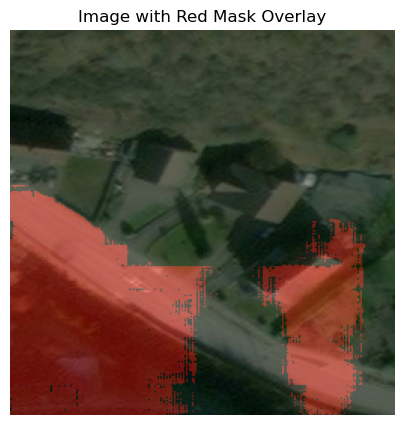

In [126]:
plot_image_with_mask(images[800], images[800].replace('training_patches', 'pred_masks_sam_dino'))

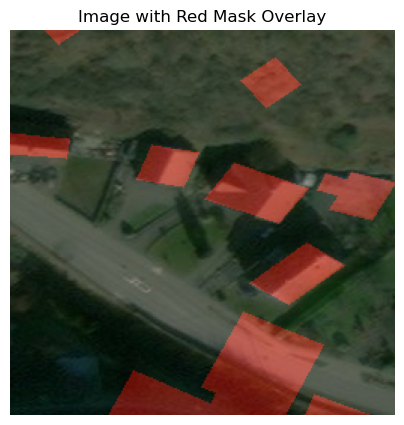

In [127]:
plot_image_with_mask(images[800], masks[800])

### Unet Training

In [63]:
df = pd.read_csv("../sub/unet_on_hand_picked.csv")
df = df["image_id"]
df = df.iloc[:500,]
df.to_csv("../sub/top500_of_unet_on_handpick.csv", index =False)
df

0      2_30_38_836_627.png
1        0_26_68_418_0.png
2        1_25_75_0_209.png
3      1_25_75_209_418.png
4       1_3_94_209_836.png
              ...         
495    0_41_59_209_209.png
496    1_13_76_627_209.png
497    1_6_104_836_836.png
498    1_16_80_627_418.png
499    1_15_81_627_209.png
Name: image_id, Length: 500, dtype: object

In [2]:
import torch
from torch.utils.data import Dataset,DataLoader, random_split
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms


In [234]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image, ImageFilter
import random

def augment_image_and_mask(image, mask):
    # Seed for reproducibility to apply the same spatial transform on both image and mask
    seed = np.random.randint(2147483647)
    
    # Spatial transformations to apply to both image and mask
    spatial_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.2)),  # Randomly crop and resize
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
    ])
    
    # Color jitter and blur applied only to the image
    photometric_transforms = transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    ])

    # Apply spatial transformations to both image and mask
    torch.manual_seed(seed)
    image = spatial_transforms(image)
    torch.manual_seed(seed)
    mask = spatial_transforms(mask)

    # Apply color jitter only to the image
    image = photometric_transforms(image)

    return image, mask

In [111]:
class myDataset(Dataset):
    def __init__(self, csvfile_dir, augment_factor=1, transform=False):
        self.data = pd.read_csv(csvfile_dir)
        self.augment_factor = augment_factor
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.data) * self.augment_factor if self.transform else len(self.data)

    def __getitem__(self, idx):
        base_idx = idx // self.augment_factor
        imageid = self.data.iloc[base_idx, 0]
        image_path = f"../data/dataset/training_patches/{imageid}"
        mask_path = image_path.replace("training_patches", "training_noisy_labels")

        # Load image and mask using OpenCV
        try:
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (256, 256))
            mask = cv2.resize(mask, (256, 256))

        except Exception as e:
            print(f"Error loading image or mask: {e}")
            image = np.zeros((256, 256, 3), dtype=np.uint8)
            mask = np.zeros((256, 256), dtype=np.uint8)

        # Convert to tensors
        image = self.to_tensor(image)
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        # Apply augmentation if required
        if self.transform:
            image, mask = augment_image_and_mask(image, mask)

        return image , mask


# Function to create DataLoaders
def get_dataloader(csv_file, batch_size=8, train_split=0.8, shuffle=True, transform=False, for_training=True):
    dataset = myDataset(csv_file, augment_factor=10, transform=transform)
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    if for_training:
        return DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        return DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class UNetMobileNetV2(nn.Module):
    def __init__(self, num_classes=1, pretrained=True, dropout_rate=0):
        super(UNetMobileNetV2, self).__init__()

        # Load the pretrained MobileNetV2 as the encoder
        mobilenet_v2 = models.mobilenet_v2(pretrained=pretrained)

        # Extract feature layers from the MobileNetV2 encoder
        self.encoder = mobilenet_v2.features
        for param in self.encoder.parameters():
            param.requires_grad = True
        # Upsampling / Decoder part
        self.upconv1 = nn.ConvTranspose2d(1280, 320, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(320 + 96, 320, dropout_rate)

        self.upconv2 = nn.ConvTranspose2d(320, 192, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(192 + 32, 192, dropout_rate)

        self.upconv3 = nn.ConvTranspose2d(192, 64, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(64 + 24, 64, dropout_rate)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(32 + 16, 32, dropout_rate)

        self.upconv5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder5 = self.conv_block(16 + 3, 16, dropout_rate)  # Adding skip connection with input

        # Final 1x1 convolution to get the desired number of output channels
        self.final_conv = nn.Conv2d(16, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels, dropout_rate):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)  # Add dropout after each convolution block
        )

    def forward(self, x):
        # Encoder: Forward through MobileNetV2
        enc1 = self.encoder[0:2](x)    # [3, 256, 256] -> [16, 128, 128]
        enc2 = self.encoder[2:4](enc1) # [16, 128, 128] -> [24, 64, 64]
        enc3 = self.encoder[4:7](enc2) # [24, 64, 64] -> [32, 32, 32]
        enc4 = self.encoder[7:14](enc3) # [32, 32, 32] -> [96, 16, 16]
        enc5 = self.encoder[14:](enc4) # [96, 16, 16] -> [1280, 8, 8]

        # Decoder: Upsample and concatenate with corresponding encoder layers
        dec1 = self.upconv1(enc5)          # [1280, 8, 8] -> [320, 16, 16]
        dec1 = torch.cat([dec1, enc4], dim=1)  # Concatenate with enc4
        dec1 = self.decoder1(dec1)         # [320 + 96, 16, 16] -> [320, 16, 16]

        dec2 = self.upconv2(dec1)          # [320, 16, 16] -> [192, 32, 32]
        dec2 = torch.cat([dec2, enc3], dim=1)  # Concatenate with enc3
        dec2 = self.decoder2(dec2)         # [192 + 32, 32, 32] -> [192, 32, 32]

        dec3 = self.upconv3(dec2)          # [192, 32, 32] -> [64, 64, 64]
        dec3 = torch.cat([dec3, enc2], dim=1)  # Concatenate with enc2
        dec3 = self.decoder3(dec3)         # [64 + 24, 64, 64] -> [64, 64, 64]

        dec4 = self.upconv4(dec3)          # [64, 64, 64] -> [32, 128, 128]
        dec4 = torch.cat([dec4, enc1], dim=1)  # Concatenate with enc1
        dec4 = self.decoder4(dec4)         # [32 + 16, 128, 128] -> [32, 128, 128]

        dec5 = self.upconv5(dec4)          # [32, 128, 128] -> [16, 256, 256]
        dec5 = torch.cat([dec5, x], dim=1)     # Concatenate with input image
        dec5 = self.decoder5(dec5)         # [16 + 3, 256, 256] -> [16, 256, 256]

        # Final output
        out = self.final_conv(dec5)        # [16, 256, 256] -> [1, 256, 256] (binary output)
        return out

In [6]:
from torch.utils.data import DataLoader
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
import torch
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer,scheduler, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_iou = 0.0

    num_batches = len(dataloader)
    for images, masks in tqdm(dataloader):
        images = images.to(device)          # [batch_size, 3, 256, 256]
        masks = masks.to(device)            # [batch_size, 1, 256, 256]
        optimizer.zero_grad()
        outputs = model(images)             # Forward pass: [batch_size, 1, 256, 256]
        loss = criterion(outputs, masks)    # Compute loss
        batch_size = images.shape[0]
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights
        running_loss += loss.item()         # Accumulate loss

       # Calculate IoU for the current batch
        preds = (torch.sigmoid(outputs) > 0.2).float()  # Threshold the outputs
        intersection = (preds * masks).sum(dim = [1,2,3])
        union = preds.sum(dim = [1,2,3]) + masks.sum(dim = [1,2,3]) - intersection
        iou = (intersection / (union + 1e-6)).mean() # Add small value to avoid division by zero
        total_iou += iou.item()  # Accumulate IoU
        
        
    scheduler.step()
    avg_loss = running_loss / num_batches
    avg_iou = total_iou / num_batches
    return avg_loss, avg_iou 


# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    total_iou = 0.0
    num_batches = len(dataloader)

    with torch.no_grad():  # Disable gradient computation
        for images, masks in tqdm(dataloader):
            images = images.to(device)      # [batch_size, 3, 256, 256]
            masks = masks.to(device)        # [batch_size, 1, 256, 256]
            batch_size = images.shape[0]
            outputs = model(images)         # Forward pass
            loss = criterion(outputs, masks)  # Compute validation loss
            running_loss += loss.item()     # Accumulate loss

            # Calculate IoU for the current batch
            preds = (torch.sigmoid(outputs) > 0.2).float()  # Threshold the outputs
            intersection = (preds * masks).sum(dim = [1,2,3])
            union = preds.sum(dim = [1,2,3]) + masks.sum(dim = [1,2,3]) - intersection
            iou = (intersection / (union + 1e-6)).mean()  # Add small value to avoid division by zero
            total_iou += iou.item()  # Accumulate IoU
            
    avg_loss = running_loss / num_batches
    avg_iou = total_iou / num_batches
    return avg_loss, avg_iou

# Inference function
def infer(model, dataloader, out_dir , criterion ,device,threshold = 0.2):
    pred_list = []
    model.eval()  # Set the model to evaluation mode
    results_list = []  # To store image and loss pairs
    with torch.no_grad():  # Disable gradient computation
        for image, mask, image_id in tqdm(dataloader):
            output_path = out_dir+f"/{image_id}"

            image = image.to(device)      # [batch_size, 3, 256, 256]
            mask = mask.to(device)        # [batch_size, 1, 256, 256]
            outputs = model(image)

            loss = criterion(outputs, mask).cpu().item()
            
            pred_mask = (torch.sigmoid(outputs) > threshold).float()  # Binary mask [1, 1, 256, 256]
            intersection = (pred_mask * mask).sum()
            union = pred_mask.sum() + mask.sum() - intersection
            iou = (intersection / (union + 1e-6)).cpu().numpy()  # Add small value to avoid division by zero

            pred_mask = pred_mask.squeeze(0).squeeze(0)
            binary_mask = pred_mask.cpu().numpy()  # Convert to numpy array
            binary_mask = (np.stack([binary_mask] * 3, axis=-1))          
            
            pred_list.append([image_id[0] ,iou,loss])
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
            # Save the predicted mask
            cv2.imwrite(output_path, binary_mask)
    return pred_list

In [8]:
from glob import glob
masks = glob("../data/dataset/training_noisy_labels/*png")
images = [i.replace("training_noisy_labels", "training_patches") for i in masks]
len(images) , len(masks)

(5000, 5000)

In [9]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import os
from torchvision import transforms
import numpy as np

class myInferDataset(Dataset):
    def __init__(self, images_list, masks_list, transform=False):
        self.transform = transform
        self.to_tensor = transforms.ToTensor()  # Transform to Tensor after augmentation
        self.images_list = images_list
        self.masks_list = masks_list

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        image_path = self.images_list[idx]
        mask_path = image_path.replace("training_patches", "training_noisy_labels")
        image_id = os.path.basename(image_path)  

        try:
            # Load image and mask using OpenCV
            image = cv2.imread(image_path)  # Read image (BGR format)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
            if image is None or mask is None:
                raise FileNotFoundError(f"File not found: {image_path} or {mask_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        except Exception as e:
            print(f"Error loading image or mask: {e}")
            # Return a dummy tensor if an error occurs
            image = np.zeros((256, 256, 3), dtype=np.uint8)
            mask = np.zeros((256, 256), dtype=np.uint8)

        if self.transform:
            # Convert both to tensors after augmentations
            image = self.to_tensor(image)  # Transforms automatically handles normalization
            mask = torch.as_tensor(mask, dtype=torch.float32).unsqueeze(0)  # Ensure mask is 1 channel

        else:
            # Normalize image manually and convert to PyTorch tensors without augmentations
            image = torch.as_tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize image to [0, 1]
            mask = torch.as_tensor(mask, dtype=torch.float32).unsqueeze(0)  # Single-channel mask

        return image,mask ,image_id
        
infer_dataset = myInferDataset(images , masks , transform=True)
infer_loader = DataLoader(infer_dataset , batch_size =1, shuffle =False)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_augmented_image_with_mask(image_tensor, mask_tensor, alpha=0.4):
    """
    Visualizes an image with a transparent red overlay for the mask.
    
    Args:
        image_tensor (torch.Tensor): The image tensor, shape (3, H, W).
        mask_tensor (torch.Tensor): The mask tensor, shape (1, H, W).
        alpha (float): Transparency level for the overlay. Default is 0.4.
    """
    # Convert image and mask tensors to numpy arrays
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
    mask_np = mask_tensor.squeeze().cpu().numpy()  # (H, W)

    # Scale values to 0-255 and convert to uint8
    image_np = (image_np * 255).astype(np.uint8)
    mask_np = (mask_np * 255).astype(np.uint8)

    # Convert to PIL images
    image_pil = Image.fromarray(image_np)
    mask_pil = Image.fromarray(mask_np)

    # Create an overlay mask with red color
    mask_overlay = Image.new("RGB", mask_pil.size, color=(255, 0, 0))
    mask_overlay = Image.composite(mask_overlay, image_pil, mask_pil)

    # Blend the original image with the red mask overlay
    blended = Image.blend(image_pil, mask_overlay, alpha=alpha)

    # Display the result
    plt.figure(figsize=(4, 4))
    plt.imshow(blended)
    plt.axis("off")
    plt.show()

In [112]:
dataset = myDataset(csvfile_dir='../sub/top1500_prev.csv', augment_factor=1, transform=False)


In [113]:
# Example usage with your dataset and DataLoader
image, mask = dataset[1]  # Fetch a single sample
image


tensor([[[0.0013, 0.0012, 0.0012,  ..., 0.0020, 0.0019, 0.0018],
         [0.0014, 0.0013, 0.0013,  ..., 0.0018, 0.0019, 0.0020],
         [0.0015, 0.0015, 0.0014,  ..., 0.0019, 0.0020, 0.0020],
         ...,
         [0.0009, 0.0009, 0.0009,  ..., 0.0011, 0.0016, 0.0020],
         [0.0008, 0.0007, 0.0007,  ..., 0.0011, 0.0014, 0.0017],
         [0.0008, 0.0007, 0.0007,  ..., 0.0008, 0.0010, 0.0012]],

        [[0.0016, 0.0016, 0.0016,  ..., 0.0022, 0.0021, 0.0020],
         [0.0017, 0.0017, 0.0016,  ..., 0.0020, 0.0021, 0.0022],
         [0.0018, 0.0018, 0.0018,  ..., 0.0022, 0.0022, 0.0022],
         ...,
         [0.0014, 0.0014, 0.0014,  ..., 0.0016, 0.0020, 0.0024],
         [0.0013, 0.0012, 0.0012,  ..., 0.0015, 0.0018, 0.0020],
         [0.0013, 0.0012, 0.0012,  ..., 0.0012, 0.0014, 0.0016]],

        [[0.0010, 0.0010, 0.0010,  ..., 0.0018, 0.0017, 0.0016],
         [0.0011, 0.0011, 0.0010,  ..., 0.0016, 0.0017, 0.0018],
         [0.0012, 0.0012, 0.0012,  ..., 0.0017, 0.0018, 0.

In [12]:
model = UNetMobileNetV2().to(device)

C:\Users\syedd\.conda\envs\comp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\syedd\.conda\envs\comp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
lr = 0.01
train_batch_size = 16
val_batch_size= 16
dropout_rate = 0
train_loader = get_dataloader('../notebooks/top92_hand_picked.csv', batch_size=train_batch_size, transform=True)
val_loader = get_dataloader('../notebooks/top92_hand_picked.csv', batch_size=val_batch_size , transform=True , for_training=False)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.4)


In [14]:
train_losses = []
val_losses = []
train_ious = []
val_ious = []


In [16]:
num_epochs = 40
for epoch in range(num_epochs):
    train_loss, train_iou = train(model, train_loader, criterion, optimizer,scheduler, device)
    val_loss, val_iou = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Train IoU: {train_iou:.8f}, '
          f'Val Loss: {val_loss:.8f}, Val IoU: {val_iou:.8f}')
    

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.56it/s]


Epoch [1/40], Train Loss: 0.11264149, Train IoU: 0.57690062, Val Loss: 0.10531612, Val IoU: 0.60839812


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.72it/s]


Epoch [2/40], Train Loss: 0.11019909, Train IoU: 0.58476129, Val Loss: 0.10523492, Val IoU: 0.61073954


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.63it/s]


Epoch [3/40], Train Loss: 0.11280969, Train IoU: 0.58205157, Val Loss: 0.10390148, Val IoU: 0.62982800


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.59it/s]


Epoch [4/40], Train Loss: 0.11036794, Train IoU: 0.59515621, Val Loss: 0.10478942, Val IoU: 0.61619342


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.74it/s]


Epoch [5/40], Train Loss: 0.10986755, Train IoU: 0.58411152, Val Loss: 0.10364970, Val IoU: 0.61850712


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.84it/s]


Epoch [6/40], Train Loss: 0.10857161, Train IoU: 0.59275548, Val Loss: 0.10291686, Val IoU: 0.62995115


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.76it/s]


Epoch [7/40], Train Loss: 0.11003990, Train IoU: 0.58703869, Val Loss: 0.10361162, Val IoU: 0.61923857


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.70it/s]


Epoch [8/40], Train Loss: 0.10865341, Train IoU: 0.59515086, Val Loss: 0.10486615, Val IoU: 0.61943388


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.79it/s]


Epoch [9/40], Train Loss: 0.10983588, Train IoU: 0.58628849, Val Loss: 0.10431119, Val IoU: 0.61554564


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.61it/s]


Epoch [10/40], Train Loss: 0.10987432, Train IoU: 0.58414434, Val Loss: 0.10158363, Val IoU: 0.62205673


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.61it/s]


Epoch [11/40], Train Loss: 0.10889074, Train IoU: 0.59019182, Val Loss: 0.10386778, Val IoU: 0.61823793


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.78it/s]


Epoch [12/40], Train Loss: 0.10817093, Train IoU: 0.58787353, Val Loss: 0.10249193, Val IoU: 0.61418949


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.55it/s]


Epoch [13/40], Train Loss: 0.10654520, Train IoU: 0.59444984, Val Loss: 0.10252062, Val IoU: 0.62186724


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.55it/s]


Epoch [14/40], Train Loss: 0.10781440, Train IoU: 0.59062150, Val Loss: 0.10237080, Val IoU: 0.62683773


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.70it/s]


Epoch [15/40], Train Loss: 0.11054864, Train IoU: 0.58295035, Val Loss: 0.10254395, Val IoU: 0.62196753


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.50it/s]


Epoch [16/40], Train Loss: 0.10739117, Train IoU: 0.59392134, Val Loss: 0.10234696, Val IoU: 0.61596420


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.66it/s]


Epoch [17/40], Train Loss: 0.10653747, Train IoU: 0.59758296, Val Loss: 0.10297309, Val IoU: 0.60450772


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.86it/s]


Epoch [18/40], Train Loss: 0.10667720, Train IoU: 0.59411874, Val Loss: 0.10159591, Val IoU: 0.62560007


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.67it/s]


Epoch [19/40], Train Loss: 0.10722298, Train IoU: 0.59559676, Val Loss: 0.10272097, Val IoU: 0.62805882


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.55it/s]


Epoch [20/40], Train Loss: 0.10821866, Train IoU: 0.58922664, Val Loss: 0.10115946, Val IoU: 0.61947439


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.58it/s]


Epoch [21/40], Train Loss: 0.10655425, Train IoU: 0.59186673, Val Loss: 0.10074503, Val IoU: 0.62259867


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.58it/s]


Epoch [22/40], Train Loss: 0.10661396, Train IoU: 0.59979246, Val Loss: 0.10173554, Val IoU: 0.63288274


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.61it/s]


Epoch [23/40], Train Loss: 0.10633588, Train IoU: 0.59883574, Val Loss: 0.10226551, Val IoU: 0.60439632


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.68it/s]


Epoch [24/40], Train Loss: 0.10667849, Train IoU: 0.60379119, Val Loss: 0.10088771, Val IoU: 0.61484794


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.77it/s]


Epoch [25/40], Train Loss: 0.10616749, Train IoU: 0.59549173, Val Loss: 0.09986961, Val IoU: 0.62159604


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.67it/s]


Epoch [26/40], Train Loss: 0.10996250, Train IoU: 0.58719525, Val Loss: 0.09841954, Val IoU: 0.62601662


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.63it/s]


Epoch [27/40], Train Loss: 0.10579597, Train IoU: 0.59617665, Val Loss: 0.10028402, Val IoU: 0.62829029


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.73it/s]


Epoch [28/40], Train Loss: 0.10627441, Train IoU: 0.59691122, Val Loss: 0.09988798, Val IoU: 0.62179780


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.64it/s]


Epoch [29/40], Train Loss: 0.10806410, Train IoU: 0.58743376, Val Loss: 0.10101828, Val IoU: 0.62722153


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.60it/s]


Epoch [30/40], Train Loss: 0.10727298, Train IoU: 0.59329572, Val Loss: 0.10242894, Val IoU: 0.61579350


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.65it/s]


Epoch [31/40], Train Loss: 0.11022367, Train IoU: 0.58686300, Val Loss: 0.10004910, Val IoU: 0.61704284


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.80it/s]


Epoch [32/40], Train Loss: 0.10641132, Train IoU: 0.59565354, Val Loss: 0.09971481, Val IoU: 0.61609514


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.05it/s]


Epoch [33/40], Train Loss: 0.10725033, Train IoU: 0.59074904, Val Loss: 0.10130185, Val IoU: 0.62256537


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.57it/s]


Epoch [34/40], Train Loss: 0.10684438, Train IoU: 0.59410490, Val Loss: 0.09830925, Val IoU: 0.63041153


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.66it/s]


Epoch [35/40], Train Loss: 0.10737900, Train IoU: 0.59354689, Val Loss: 0.10123967, Val IoU: 0.61716962


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.56it/s]


Epoch [36/40], Train Loss: 0.10648300, Train IoU: 0.58953926, Val Loss: 0.10248907, Val IoU: 0.62520068


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.72it/s]


Epoch [37/40], Train Loss: 0.10584502, Train IoU: 0.59634017, Val Loss: 0.10097057, Val IoU: 0.62876196


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.64it/s]


Epoch [38/40], Train Loss: 0.10643603, Train IoU: 0.59127272, Val Loss: 0.10022702, Val IoU: 0.62527942


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.67it/s]


Epoch [39/40], Train Loss: 0.10687708, Train IoU: 0.59459905, Val Loss: 0.10118841, Val IoU: 0.62890288


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.38it/s]

Epoch [40/40], Train Loss: 0.10691413, Train IoU: 0.59545185, Val Loss: 0.10286162, Val IoU: 0.61169379


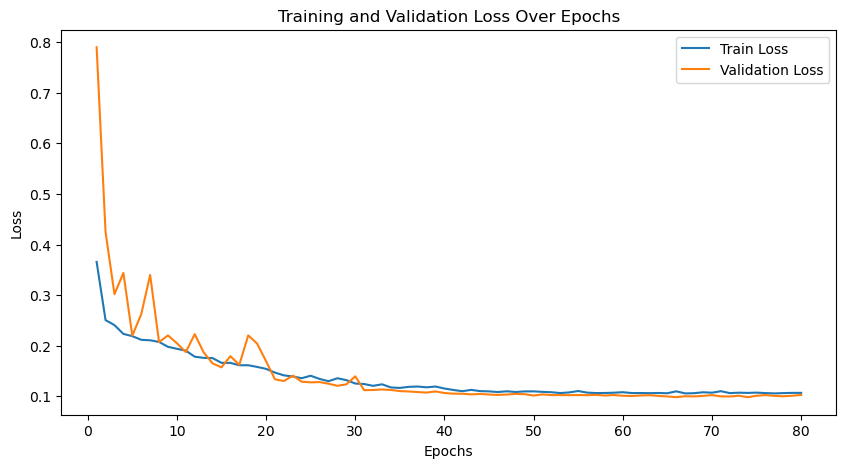

In [17]:
# Plotting the losses
num_epochs = 80
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')

# Adding titles and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

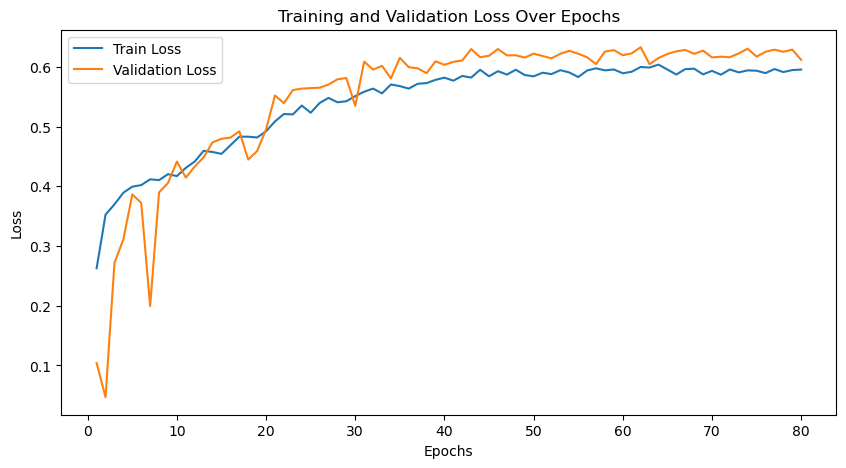

In [18]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_ious, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_ious, label='Validation Loss')

# Adding titles and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

In [61]:
results = infer(model , infer_loader ,"../data/dataset/unet_on_handpicked", criterion ,device)
len(results)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:53<00:00, 93.79it/s]


5000

In [20]:
len(results)

5000

In [25]:
df = pd.DataFrame(results, columns=["image_id","iou","loss"])
df.loc[df['iou'] == 0, 'iou'] = 1
df = df.sort_values("iou", ascending=False).reset_index(drop=True)
df["id"] = df.index
df_iou = df[["iou", "image_id"]]
df_sub = df[["id", "image_id"]]

In [26]:
df_sub.to_csv("../sub/unet_on_hand_picked.csv", index=False)
df_iou.to_csv("../sub/unet_on_hand_picked_raw.csv", index=False)

In [339]:
df_iou

,iou,image_id
0,0.8264871,1_16_81_0_627.png
1,0.7741559,1_7_87_1044_1044.png
2,0.7581349,2_26_34_0_1044.png
3,0.73997253,1_11_87_836_418.png
4,0.7308055,1_16_80_836_418.png
...,...,...
4995,0.0,2_20_44_0_836.png
4996,0.0,1_18_71_418_209.png
4997,0.0,2_20_44_0_1044.png
4998,0.0,0_41_62_0_627.png


In [300]:
top1000 = df_sub.iloc[:1000,1]
top1000

0         1_16_81_0_627.png
1      1_7_87_1044_1044.png
2        2_26_34_0_1044.png
3       1_11_87_836_418.png
4       1_16_80_836_418.png
               ...         
995     0_29_63_836_209.png
996    2_21_44_1044_627.png
997     1_10_88_627_627.png
998       0_27_68_0_209.png
999    0_29_63_1044_418.png
Name: image_id, Length: 1000, dtype: object

In [302]:
top1000 = df_sub.iloc[:1000,1]
top1000.to_csv("../sub/top1000_of_unet_500.csv", index=False)

In [209]:
# infer_and_plot_binary_mask(model, infer_loader, criterion, device, threshold=0.7)
# idx = 1
# # plot_image_with_mask(images[idx],masks[idx])

In [356]:
%cd

C:\Users\syedd


Fine tuning the encoder part of model also 

In [303]:
model2 = UNetMobileNetV2().to(device)

In [ ]:
lr = 0.001
train_batch_size = 16
val_batch_size= 16
dropout_rate = 0
train_loader = get_dataloader('../sub/top1000_of_unet_500.csv', batch_size=train_batch_size, transform=False)
val_loader = get_dataloader('../sub/top1000_of_unet_500.csv', batch_size=val_batch_size , transform=False , for_training=False)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [106]:
ious

[]

In [218]:
idx  = 2
top500 = pd.read_csv("../sub/top500.csv")
# plt.imshow(cv2.imread(f"../data/dataset/training_patches/{top500.iloc[idx,0]}"))
plot_image_with_mask(f"../data/dataset/training_patches/{top500.iloc[idx,0]}", f"../data/dataset/training_noisy_labels/{top500.iloc[idx,0]}")

In [219]:
# Plotting the losses
num_epochs = 40
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')

# Adding titles and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

In [220]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_ious, label='Train ious')
plt.plot(range(1, num_epochs+1), val_ious, label='Validation ious')

# Adding titles and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

In [16]:
# Inference function
def infer(model, dataloader, criterion, device,threshold = 0.2):
    pred_list = []
    model.eval()  # Set the model to evaluation mode
    results_list = []  # To store image and loss pairs
    with torch.no_grad():  # Disable gradient computation
        for image, mask, image_id in tqdm(dataloader):
            output_path = f'../data/dataset/pred_mask_with_unet500/{image_id[0]}'

            image = image.to(device)      # [batch_size, 3, 256, 256]
            mask = mask.to(device)        # [batch_size, 1, 256, 256]
            outputs = model2(image)

            loss = criterion(outputs, mask).cpu().item()
            
            pred_mask = (torch.sigmoid(outputs) > threshold).float()  # Binary mask [1, 1, 256, 256]
            intersection = (pred_mask * mask).sum()
            union = pred_mask.sum() + mask.sum() - intersection
            iou = (intersection / (union + 1e-6)).cpu().numpy()  # Add small value to avoid division by zero

            pred_mask = pred_mask.squeeze(0).squeeze(0)
            binary_mask = pred_mask.cpu().numpy()  # Convert to numpy array
            binary_mask = (np.stack([binary_mask] * 3, axis=-1))          
            
            pred_list.append([image_id[0] ,iou,loss])
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
            # Save the predicted mask
            cv2.imwrite(output_path, binary_mask)
    return pred_list

In [17]:
results = infer(model2 , infer_loader , criterion , device)
len(results)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:12<00:00, 68.71it/s]


5000

In [38]:
df = pd.DataFrame(results, columns=["image_id","iou","loss"])
df_iou = df.drop(columns = 'loss').sort_values("iou", ascending=False)
df_iou_for_voxel = df_iou
df_iou = df_iou.reset_index(drop=True)
df_iou["id"] = df_iou.index
df_iou = df_iou[["id", "image_id"]]

In [44]:
df_iou.to_csv("../sub/unet500.csv", index=False)
df_iou_for_voxel.to_csv("../sub/unet500to5000.csv", index=False)
top1000 = df_iou.iloc[:1000,1]

In [45]:
top1000.to_csv("../sub/top1000.csv", index=False)


In [6]:
model3 = UNetMobileNetV2(num_classes=1, pretrained=True, dropout_rate=0).to(device)

C:\Users\syedd\.conda\envs\comp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\syedd\.conda\envs\comp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
lr = 0.05
train_batch_size = 16
val_batch_size= 16
dropout_rate = 0
train_loader = get_train_dataloader('../sub/top1000.csv', batch_size=train_batch_size, transform=True)
val_loader = get_val_dataloader('../sub/top1000.csv', batch_size=val_batch_size )
optimizer = optim.Adam(model3.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.4)


In [9]:
train_losses = []
val_losses = []
train_ious = []
val_ious = []


In [221]:
num_epochs = 40


for epoch in range(num_epochs):
    train_loss, train_iou = train(model3, train_loader, criterion, optimizer,scheduler, device)
    val_loss, val_iou = validate(model3, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Train IoU: {train_iou:.8f}, '
          f'Val Loss: {val_loss:.8f}, Val IoU: {val_iou:.8f}')
    

In [167]:
new_images = glob("../data/dataset/New_dataset/Images/*.jpg")
new_masks = [i.replace("Images" , "Masks") for i in new_images]
new_masks = [j.replace("jpg","tif") for j in new_masks]

In [168]:
len(new_images) , len(new_masks)

(201, 201)

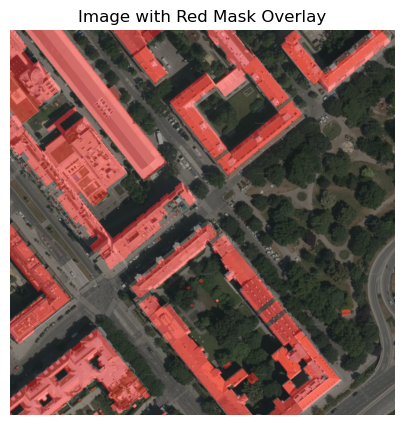

In [169]:
plot_image_with_mask(new_images[200],new_masks[200])

In [258]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

class ResizedImageDataset(Dataset):
    def __init__(self, images, masks, augment_factor=1, transform=False):
        self.images = images
        self.masks = masks
        self.augment_factor = augment_factor
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        # Each image produces 16 patches
        return len(self.images) * 16 * self.augment_factor if self.transform else len(self.images) * 16

    def __getitem__(self, idx):
        # Determine the image and patch index
        image_idx = idx // (16 * self.augment_factor)  # Original image index
        patch_idx = (idx // self.augment_factor) % 16  # Patch index (0-15 within a 1024x1024 image)
        
        # Load the 1024x1024 image and mask
        image_path = self.images[image_idx]
        mask_path = self.masks[image_idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Calculate the coordinates for the 256x256 patch
        x_offset = (patch_idx % 4) * 256
        y_offset = (patch_idx // 4) * 256
        image_patch = image[y_offset:y_offset + 256, x_offset:x_offset + 256]
        mask_patch = mask[y_offset:y_offset + 256, x_offset:x_offset + 256]

        # Convert to tensors and scale values to [0, 1]
        image_patch = self.to_tensor(image_patch)
        mask_patch = torch.from_numpy(mask_patch).float() / 255.0
        mask_patch = mask_patch.unsqueeze(0)  # Add channel dimension for mask

        # Apply augmentation if required
        if self.transform:
            image_patch, mask_patch = augment_image_and_mask(image_patch, mask_patch)

        return image_patch, mask_patch

In [257]:
idx = 200
dataset  = ResizedImageDataset(new_images,new_masks , transform=False)
image,mask = dataset[idx]
plt.imshow(mask.permute(2,1,0).cpu().numpy())
plt.imshow(image.permute(2,1,0).cpu().numpy())


In [245]:
model4 = UNetMobileNetV2(num_classes=1, pretrained=True, dropout_rate=0).to(device)

C:\Users\syedd\.conda\envs\comp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\syedd\.conda\envs\comp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [266]:
import torch

dataset = ResizedImageDataset(new_images, new_masks, augment_factor=1, transform=True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 16
lr = 0.05
dropout_rate = 0

optimizer = optim.Adam(model4.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.4)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [264]:
train_losses = []
val_losses = []
train_ious = []
val_ious = []


In [ ]:
num_epochs = 40

for epoch in range(num_epochs):
    train_loss, train_iou = train(model4, train_loader, criterion, optimizer,scheduler, device)
    val_loss, val_iou = validate(model4, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Train IoU: {train_iou:.8f}, '
          f'Val Loss: {val_loss:.8f}, Val IoU: {val_iou:.8f}')
    

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:18<00:00,  2.17it/s]


Epoch [1/38], Train Loss: 0.29826625, Train IoU: 0.18403687, Val Loss: 0.39017421, Val IoU: 0.16632039


 29%|███████████████████████▏                                                         | 46/161 [00:21<00:54,  2.11it/s]